In [1]:
import time
t_start = time.time()

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # suppress tensorflow information messages

import sys
import numpy as np
from scipy import stats
import scipy as sp
import multiprocessing
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")
print("Home path:", HOME_PATH)

# custom modules
import paper_plot as pp
import full_data as data
import nn
import training 

Home path: /root/work/QE-mls
['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthMET', '/TruthNu0', '/TruthNu1', '/TruthW0', '/TruthW1']


In [2]:
# ROOT need to be imported after tensorflow
import ROOT
from ROOT import TLorentzVector, TVector3

# some global variables
dir_name = HOME_PATH + "/14th_trial/reg_main/ww_resregressor_result/"
plot = pp.Plotter()
WORKERS = 32

In [3]:
import h5py


def load_particles_from_h5(filename="mc20_truth.h5"):
    """
    Load particle data from an HDF5 file

    Args:
        filename: Path to the HDF5 file

    Returns:
        Dictionary with the loaded data
    """
    result = {}

    with h5py.File(filename, "r") as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}

            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]

            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value

            result[group_name] = group_data

    return result

In [4]:
def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)


def deta(eta1, eta2):
    return np.abs(eta1 - eta2)


def dphi_pi(phi1, phi2):
    phi_diff = phi1 - phi2
    phi_diff = np.where(phi_diff < 0.0, -phi_diff, phi_diff)
    phi_diff = np.where(phi_diff > 2.0 * np.pi, phi_diff - 2.0 * np.pi, phi_diff)
    phi_diff = np.where(phi_diff >= np.pi, 2.0 * np.pi - phi_diff, phi_diff)
    return np.divide(phi_diff, np.pi)

In [5]:
mc20_data = load_particles_from_h5("/root/data/mc20_truth.h5")
mc20_data.keys()

dict_keys(['higgs', 'lead_w', 'sublead_w', 'truth_dilep', 'truth_dilep_car', 'truth_lead_lep', 'truth_lead_lep_car', 'truth_lead_nu', 'truth_lead_nu_car', 'truth_sublead_lep', 'truth_sublead_lep_car', 'truth_sublead_nu', 'truth_sublead_nu_car'])

In [6]:
# SM truth
truth_lead_lep = mc20_data["truth_lead_lep"]
truth_sublead_lep = mc20_data["truth_sublead_lep"]
truth_lead_nu = mc20_data["truth_lead_nu"]
truth_sublead_nu = mc20_data["truth_sublead_nu"]
truth_lead_lep_p4 = mc20_data["truth_lead_lep"]["p4"]
truth_sublead_lep_p4 = mc20_data["truth_sublead_lep"]["p4"]
truth_lead_nu_p4 = mc20_data["truth_lead_nu"]["p4"]
truth_sublead_nu_p4 = mc20_data["truth_sublead_nu"]["p4"]
truth_met_pt = np.sqrt(np.square((truth_lead_nu_p4 + truth_sublead_nu_p4)[...,0:2]).sum(axis=-1))

# CAR truth
truth_lead_lep_car = mc20_data["truth_lead_lep_car"]
truth_sublead_lep_car = mc20_data["truth_sublead_lep_car"]
truth_lead_nu_car = mc20_data["truth_lead_nu_car"]
truth_sublead_nu_car = mc20_data["truth_sublead_nu_car"]
truth_lead_lep_car_p4 = mc20_data["truth_lead_lep_car"]["p4"]
truth_sublead_lep_car_p4 = mc20_data["truth_sublead_lep_car"]["p4"]
truth_lead_nu_car_p4 = mc20_data["truth_lead_nu_car"]["p4"]
truth_sublead_nu_car_p4 = mc20_data["truth_sublead_nu_car"]["p4"]
truth_met_pt_car = np.sqrt(np.square((truth_lead_nu_car_p4 + truth_sublead_nu_car_p4)[...,0:2]).sum(axis=-1))

# W bosons (SM and CAR use the same W bosons data)
w_lead_p4 = mc20_data["lead_w"]["p4"]
w_sublead_p4 = mc20_data["sublead_w"]["p4"]

In [7]:
truth_lead_lep["energy"]

array([ 58.04127 ,  55.986347, 117.83698 , ..., 240.05261 , 353.5572  ,
        36.1946  ], dtype=float32)

In [8]:
###############################################
# Truth sudy --> do not use cut at beginning! #
###############################################

print("Truth: pre-cut")
cut_pre_pt_lead = truth_lead_lep["pt"] > 22
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep["pt"] > 15
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"])
    - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"])
    - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"])
    - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"])
    > 10**2
)
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt > 20
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep["energy"]) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)
# print(f'''
# Check minimum cuts for each variables:
# - pt_lead: {np.min(truth_lead_lep["pt"])}
# - pt_sublead: {np.min(truth_sublead_lep["pt"])}
# - dilep_m: {np.min(np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"]) - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"]) - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"]) - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"]))}
# - pt_miss: {np.min(truth_met_pt)}
# - eta_lead: {np.min(np.abs(truth_lead_lep["eta"]))}
# - eta_sublead: {np.min(np.abs(truth_sublead_lep["eta"]))}
# - phi_lead: {np.min(np.abs(truth_lead_lep["phi"]))}
# - phi_sublead: {np.min(np.abs(truth_sublead_lep["phi"]))}
# ''')

# CAR
print("")
print("CAR: pre-cut")
cut_pre_pt_lead = truth_lead_lep_car["pt"] > 22
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep_car["pt"] > 15
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep_car["energy"] + truth_sublead_lep_car["energy"])
    - np.square(truth_lead_lep_car["px"] + truth_sublead_lep_car["px"])
    - np.square(truth_lead_lep_car["py"] + truth_sublead_lep_car["py"])
    - np.square(truth_lead_lep_car["pz"] + truth_sublead_lep_car["pz"])
    > 10**2
)
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt_car > 20
print(len(truth_lead_lep_car["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT_CAR = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep_car["energy"]) - np.sum(PRE_CUT_CAR * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)
# print(f'''
# Check minimum cuts for each variables:
# - pt_lead: {np.min(truth_lead_lep_car["pt"])}
# - pt_sublead: {np.min(truth_sublead_lep_car["pt"])}
# - dilep_m: {np.min(np.square(truth_lead_lep_car["energy"] + truth_sublead_lep_car["energy"]) - np.square(truth_lead_lep_car["px"] + truth_sublead_lep_car["px"]) - np.square(truth_lead_lep_car["py"] + truth_sublead_lep_car["py"]) - np.square(truth_lead_lep_car["pz"] + truth_sublead_lep_car["pz"]))}
# - pt_miss: {np.min(truth_met_pt_car)}
# - eta_lead: {np.min(np.abs(truth_lead_lep_car["eta"]))}
# - eta_sublead: {np.min(np.abs(truth_sublead_lep_car["eta"]))}
# - phi_lead: {np.min(np.abs(truth_lead_lep_car["phi"]))}
# - phi_sublead: {np.min(np.abs(truth_sublead_lep_car["phi"]))}
# ''')

Truth: pre-cut
260653
1174171
148392
287355
Total 1502903

CAR: pre-cut
336735
1292162
65248
441435
Total 1634918


In [9]:
# force to use the same cuts for both truth and CAR

PRE_CUT_INST = PRE_CUT_CAR & PRE_CUT
print("Total", len(truth_lead_lep_car["energy"]) - np.sum(PRE_CUT_INST * 1))

Total 2263114


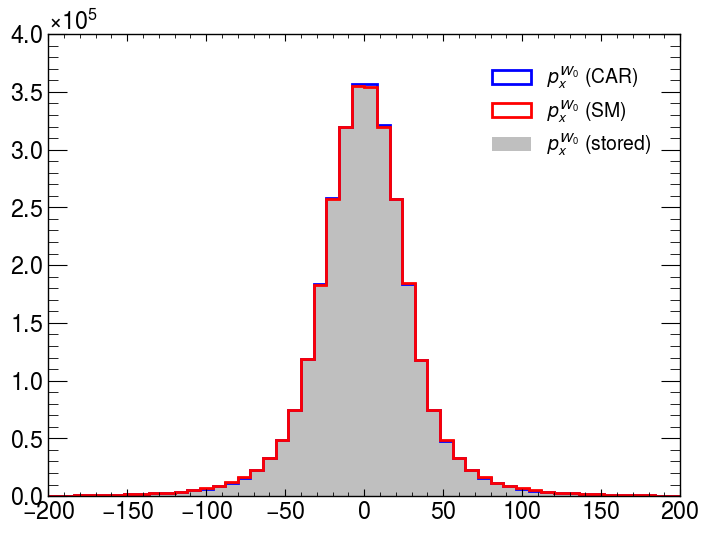

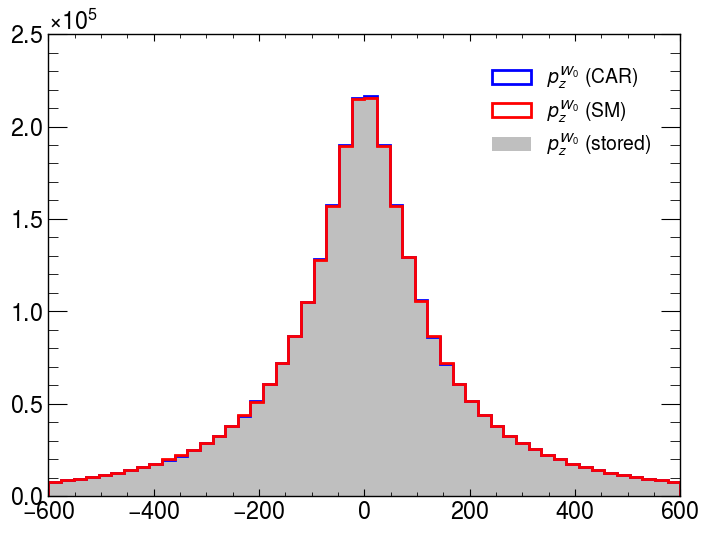

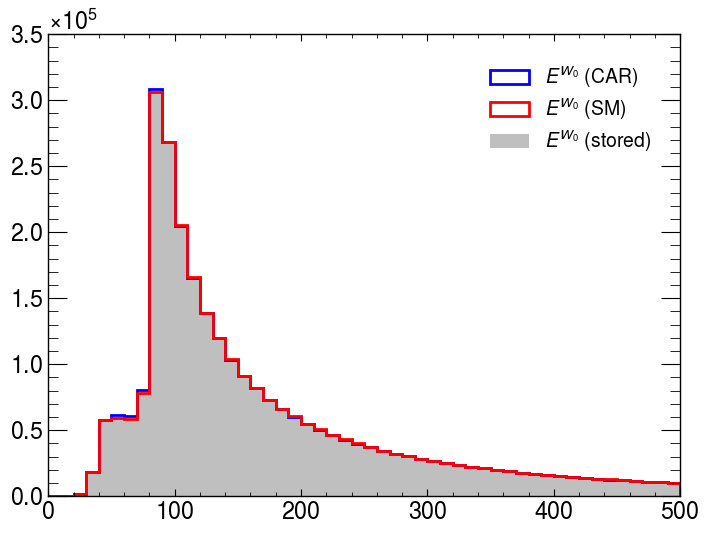

In [10]:
# truth-level checking 
truth_lead_w = truth_lead_lep_p4 + truth_lead_nu_p4
truth_sublead_w = truth_sublead_lep_p4 + truth_sublead_nu_p4
truth_lead_w_car = truth_lead_lep_car_p4 + truth_lead_nu_car_p4
truth_sublead_w_car = truth_sublead_lep_car_p4 + truth_sublead_nu_car_p4
plt.hist(truth_lead_w_car[:,0], bins=np.linspace(-200, 200, 51), label=r"$p_x^{W_0}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lead_w[:,0], bins=np.linspace(-200, 200, 51), label=r"$p_x^{W_0}$ (SM)", histtype="step", linewidth=2, color="red")
plt.hist(w_lead_p4[:,0], bins=np.linspace(-200, 200, 51), label=r"$p_x^{W_0}$ (stored)", histtype="bar", alpha=.5, color="grey")
plt.legend()
plt.show()

plt.hist(truth_lead_w_car[:,2], bins=np.linspace(-600, 600, 51), label=r"$p_z^{W_0}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lead_w[:,2], bins=np.linspace(-600, 600, 51), label=r"$p_z^{W_0}$ (SM)", histtype="step", linewidth=2, color="red")
plt.hist(w_lead_p4[:,2], bins=np.linspace(-600, 600, 51), label=r"$p_z^{W_0}$ (stored)", histtype="bar", alpha=.5, color="grey")
plt.legend()
plt.show()

plt.hist(truth_lead_w_car[:,3], bins=np.linspace(0, 500, 51), label=r"$E^{W_0}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lead_w[:,3], bins=np.linspace(0, 500, 51), label=r"$E^{W_0}$ (SM)", histtype="step", linewidth=2, color="red")
plt.hist(w_lead_p4[:,3], bins=np.linspace(0, 500, 51), label=r"$E^{W_0}$ (stored)", histtype="bar", alpha=.5, color="grey")
plt.legend()
plt.show()

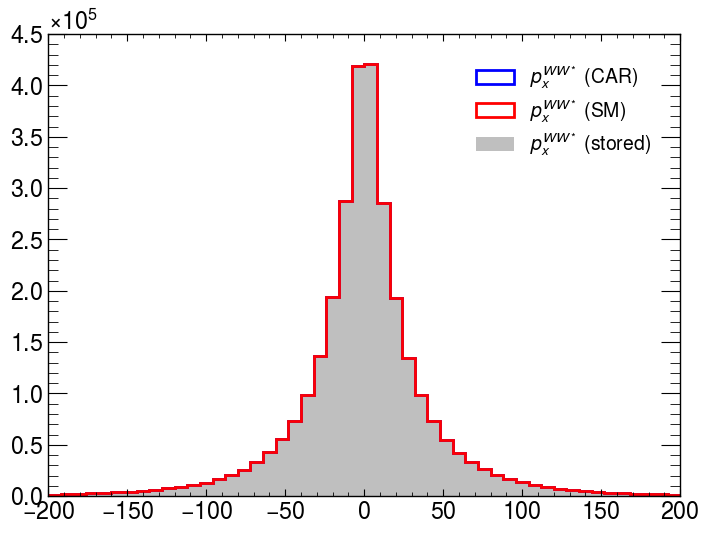

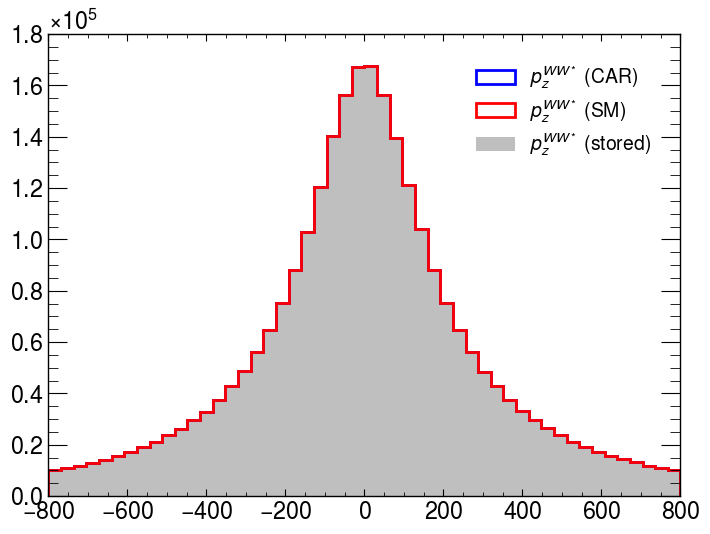

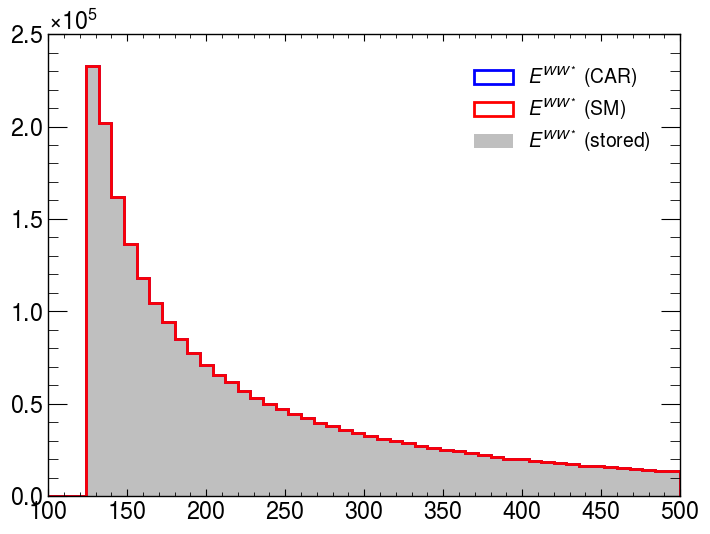

In [11]:
# truth-level checking 
truth_lead_w = truth_lead_lep_p4 + truth_lead_nu_p4
truth_sublead_w = truth_sublead_lep_p4 + truth_sublead_nu_p4
truth_ww = truth_lead_w + truth_sublead_w
truth_lead_w_car = truth_lead_lep_car_p4 + truth_lead_nu_car_p4
truth_sublead_w_car = truth_sublead_lep_car_p4 + truth_sublead_nu_car_p4
truth_ww_car = truth_lead_w_car + truth_sublead_w_car
ww = w_lead_p4 + w_sublead_p4
plt.hist(truth_ww_car[:,0], bins=np.linspace(-200, 200, 51), label=r"$p_x^{WW^\ast}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_ww[:,0], bins=np.linspace(-200, 200, 51), label=r"$p_x^{WW^\ast}$ (SM)", histtype="step", linewidth=2, color="red")
plt.hist(ww[:,0], bins=np.linspace(-200, 200, 51), label=r"$p_x^{WW^\ast}$ (stored)", histtype="bar", alpha=.5, color="grey")
plt.legend()
plt.show()

plt.hist(truth_ww_car[:,2], bins=np.linspace(-800, 800, 51), label=r"$p_z^{WW^\ast}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_ww[:,2], bins=np.linspace(-800, 800, 51), label=r"$p_z^{WW^\ast}$ (SM)", histtype="step", linewidth=2, color="red")
plt.hist(ww[:,2], bins=np.linspace(-800, 800, 51), label=r"$p_z^{WW^\ast}$ (stored)", histtype="bar", alpha=.5, color="grey")
plt.legend()
plt.show()

plt.hist(truth_ww_car[:,3], bins=np.linspace(100, 500, 51), label=r"$E^{WW^\ast}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_ww[:,3], bins=np.linspace(100, 500, 51), label=r"$E^{WW^\ast}$ (SM)", histtype="step", linewidth=2, color="red")
plt.hist(ww[:,3], bins=np.linspace(100, 500, 51), label=r"$E^{WW^\ast}$ (stored)", histtype="bar", alpha=.5, color="grey")
plt.legend()
plt.show()

In [12]:
# mc20 truth

mc20_true_obs_kin = np.column_stack(
    (
        truth_lead_lep["px"],
        truth_lead_lep["py"],
        truth_lead_lep["pz"],
        truth_lead_lep["energy"],
        truth_sublead_lep["px"],
        truth_sublead_lep["py"],
        truth_sublead_lep["pz"],
        truth_sublead_lep["energy"],
        truth_lead_nu["px"] + truth_sublead_nu["px"],
        truth_lead_nu["py"] + truth_sublead_nu["py"],
    )
)
# trim the data
print("mc20 (true) obs_kin shape:", mc20_true_obs_kin.shape)
mc20_true_obs_kin = mc20_true_obs_kin[PRE_CUT_INST]
print("After selection ...\nmc20 (true) obs_kin shape:", mc20_true_obs_kin.shape)

mc20 (true) obs_kin shape: (2963488, 10)
After selection ...
mc20 (true) obs_kin shape: (700374, 10)


In [13]:
# mc20 truth (car)

mc20_car_obs_kin = np.column_stack(
    (
        truth_lead_lep_car["px"],
        truth_lead_lep_car["py"],
        truth_lead_lep_car["pz"],
        truth_lead_lep_car["energy"],
        truth_sublead_lep_car["px"],
        truth_sublead_lep_car["py"],
        truth_sublead_lep_car["pz"],
        truth_sublead_lep_car["energy"],
        truth_lead_nu_car["px"] + truth_sublead_nu_car["px"],
        truth_lead_nu_car["py"] + truth_sublead_nu_car["py"],
    )
)

print("mc20 (car) obs_kin shape:", mc20_car_obs_kin.shape)
mc20_car_obs_kin = mc20_car_obs_kin[PRE_CUT_INST]
print("After selection ...\nmc20 (car) obs_kin shape:", mc20_car_obs_kin.shape)

mc20 (car) obs_kin shape: (2963488, 10)
After selection ...
mc20 (car) obs_kin shape: (700374, 10)


In [14]:
# Kinematics of interesting variables (target for training)
w_lead = mc20_data["lead_w"]
w_sublead = mc20_data["sublead_w"]
mc20_w_kin = np.column_stack(
    (
        w_lead["px"],
        w_lead["py"],
        w_lead["pz"],
        w_lead["energy"],
        w_sublead["px"],
        w_sublead["py"],
        w_sublead["pz"],
        w_sublead["energy"],
        w_lead["m"],
        w_sublead["m"],
    )
)
# trim the data
print("mc20 w_kin shape:", mc20_w_kin.shape)

mc20 w_kin shape: (2963488, 10)


In [ ]:
# Ensure ROOT is properly initialized
ROOT.gROOT.SetBatch(True)
def Bij(particles):

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4]) # (px, py, pz, energy)
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])
    lab_lp = np.array([WpLepton.X(), WpLepton.Y(), WpLepton.Z(), WpLepton.T()])
    lab_ln = np.array([WnLepton.X(), WnLepton.Y(), WnLepton.Z(), WnLepton.T()])
    
    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)
    
    # momentum in Higgs rest frame - extract components properly
    higgs_rest_WpLepton = np.array([WpLepton.X(), WpLepton.Y(), WpLepton.Z(), WpLepton.T()])
    higgs_rest_WnLepton = np.array([WnLepton.X(), WnLepton.Y(), WnLepton.Z(), WnLepton.T()])

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    # Also fix the W rest frame arrays to extract components properly
    w_rest_WpLepton = np.array([WpLepton.X(), WpLepton.Y(), WpLepton.Z(), WpLepton.T()])
    w_rest_WnLepton = np.array([WnLepton.X(), WnLepton.Y(), WnLepton.Z(), WnLepton.T()])

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        lab_lp,
        lab_ln,
        higgs_rest_WpLepton,
        higgs_rest_WnLepton,
        w_rest_WpLepton,
        w_rest_WnLepton,
    )


def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))

    # Unpack the results
    bij, xi_p, xi_n, lab_lp, lab_ln, h_rest_lp, h_rest_ln, w_rest_lp, w_rest_ln = zip(*results)

    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    lab_lp = np.vstack(lab_lp)
    lab_ln = np.vstack(lab_ln)
    h_rest_lp = np.vstack(h_rest_lp)
    h_rest_ln = np.vstack(h_rest_ln)
    w_rest_lp = np.vstack(w_rest_lp)
    w_rest_ln = np.vstack(w_rest_ln)
    mask = np.any(np.isnan(bij), axis=1)
    print("Number of NaN values in bij:", np.sum(mask))
    return (
        bij,
        xi_p,
        xi_n,
        mask,
        lab_lp,
        lab_ln,
        h_rest_lp,
        h_rest_ln,
        w_rest_lp,
        w_rest_ln,
    )

In [16]:
"""
CGLMP and xi:

ground truth for SM
"""

mc20_truth_lead_lep_p4 = mc20_data["truth_lead_lep"]["p4"]
mc20_truth_sublead_lep_p4 = mc20_data["truth_sublead_lep"]["p4"]

# mc20_particles = np.concatenate(
#     [
#         mc20_w_kin[:, 0:4][PRE_CUT_INST],
#         mc20_truth_lead_lep_p4[PRE_CUT_INST],
#         mc20_w_kin[:, 4:8][PRE_CUT_INST],
#         mc20_truth_sublead_lep_p4[PRE_CUT_INST],
#     ],
#     axis=1,
# )
mc20_particles = np.concatenate(
    [
        mc20_w_kin[:, 0:4],
        mc20_truth_lead_lep_p4,
        mc20_w_kin[:, 4:8],
        mc20_truth_sublead_lep_p4,
    ],
    axis=1,
)
(
    truth_bij,
    truth_xi_p,
    truth_xi_n,
    truth_mask,
    truth_lab_lp,
    truth_lab_ln,
    truth_h_rest_lp,
    truth_h_rest_ln,
    truth_w_rest_lp,
    truth_w_rest_ln,
) = result_generator(mc20_particles)

Number of NaN values in bij: 0


In [17]:
"""
CGLMP and xi:

ground truth for CAR
"""

mc20_truth_lead_lep_car_p4 = mc20_data["truth_lead_lep_car"]["p4"]
mc20_truth_sublead_lep_car_p4 = mc20_data["truth_sublead_lep_car"]["p4"]

# mc20_particles = np.concatenate(
#     [
#         mc20_w_kin[:, 0:4][PRE_CUT_INST],
#         mc20_truth_lead_lep_car_p4[PRE_CUT_INST],
#         mc20_w_kin[:, 4:8][PRE_CUT_INST],
#         mc20_truth_sublead_lep_car_p4[PRE_CUT_INST],
#     ],
#     axis=1,
# )
mc20_particles = np.concatenate(
    [
        mc20_w_kin[:, 0:4],
        mc20_truth_lead_lep_car_p4,
        mc20_w_kin[:, 4:8],
        mc20_truth_sublead_lep_car_p4,
    ],
    axis=1,
)

(
    truth_bij_car, 
    truth_xi_p_car, 
    truth_xi_n_car, 
    truth_mask_car,
    truth_lab_lp_car, 
    truth_lab_ln_car,
    truth_h_rest_lp_car, 
    truth_h_rest_ln_car, 
    truth_w_rest_lp_car, 
    truth_w_rest_ln_car
) = result_generator(mc20_particles)

# truth_bij_car_yz_mask = (truth_bij_car[:, 1] > 10) & (truth_bij_car[:, 1] < 20.4)
# truth_bij_car_zx_mask = (truth_bij_car[:, 2] > 10) & (truth_bij_car[:, 2] < 20.4)
truth_bij_car_yz_mask = truth_bij_car[:, 1] > 20.4
truth_bij_car_zx_mask = truth_bij_car[:, 2] > 20.4

Number of NaN values in bij: 0


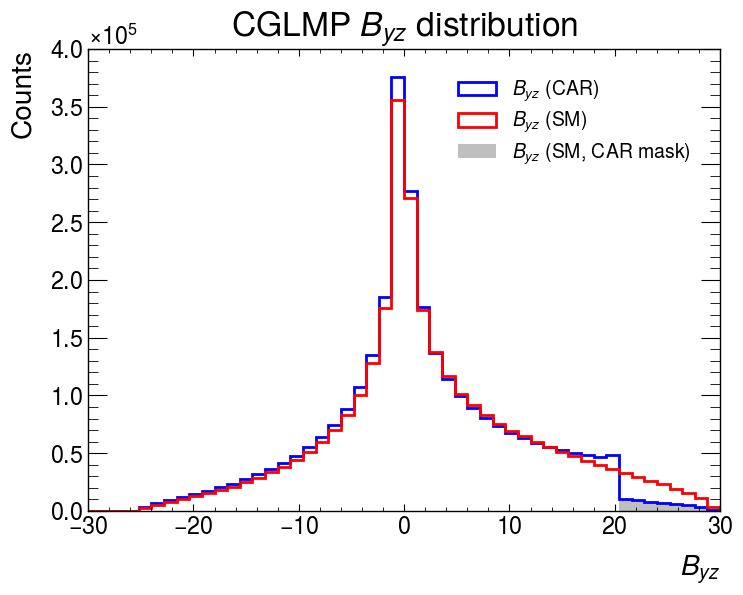

In [18]:
plt.hist(truth_bij_car[:, 1], bins=np.linspace(-30, 30, 51), label=r"$B_{yz}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_bij[:, 1], bins=np.linspace(-30, 30, 51), label=r"$B_{yz}$ (SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_bij_car[:, 1][truth_bij_car_yz_mask], bins=np.linspace(-30, 30, 51), label=r"$B_{yz}$ (SM, CAR mask)", histtype="bar", alpha=.5, color="grey")
plt.legend()
plt.xlabel(r"$B_{yz}$")
plt.ylabel("Counts")
plt.title("CGLMP $B_{yz}$ distribution")
plt.show()

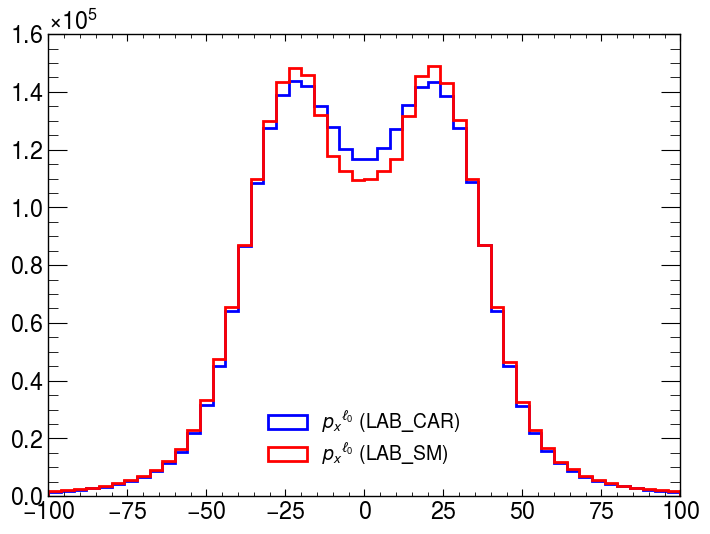

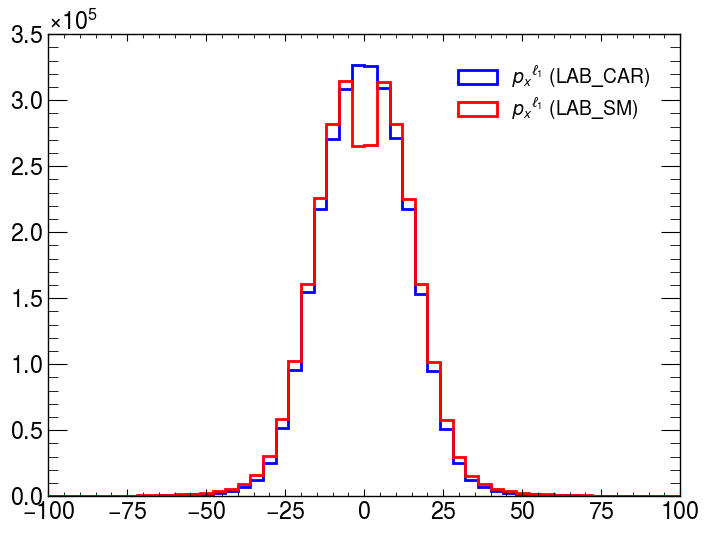

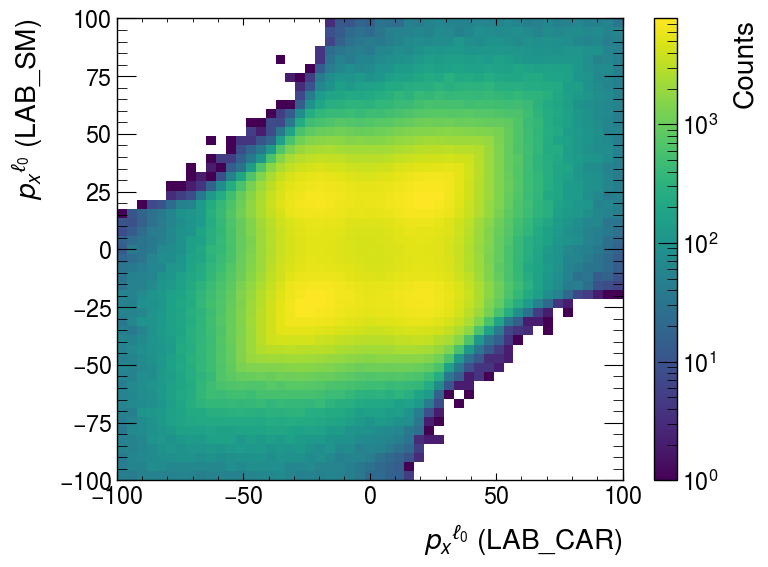

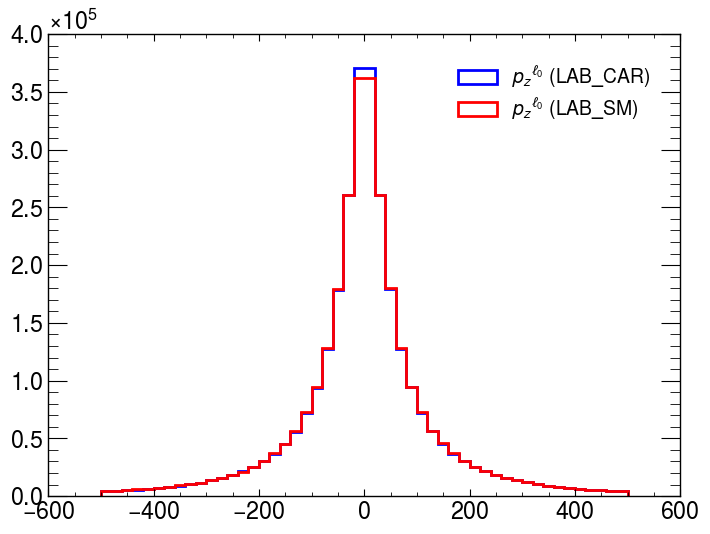

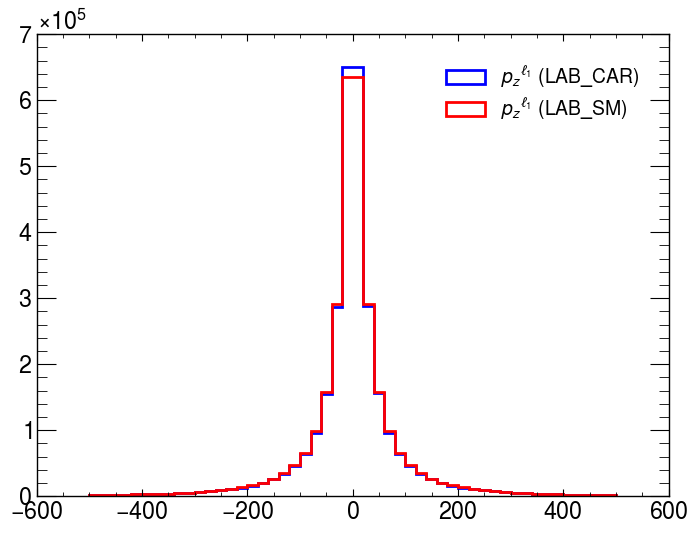

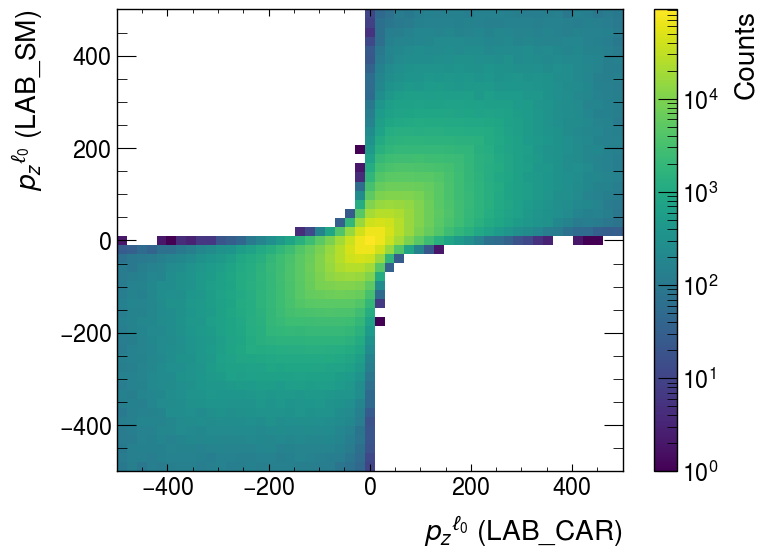

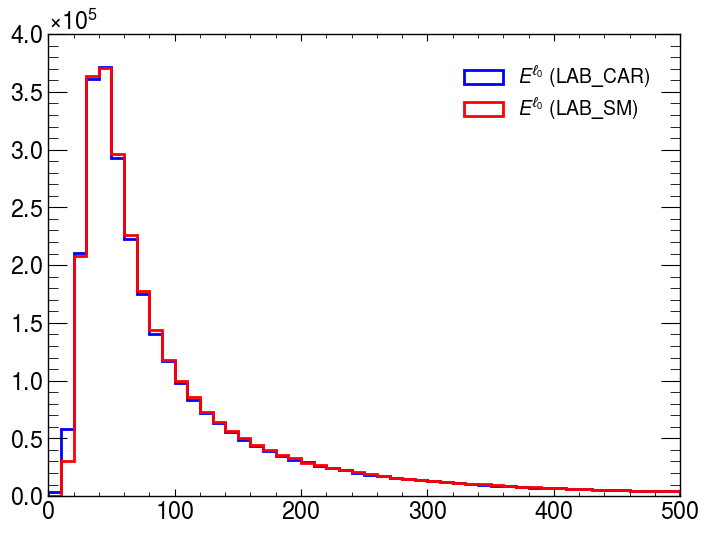

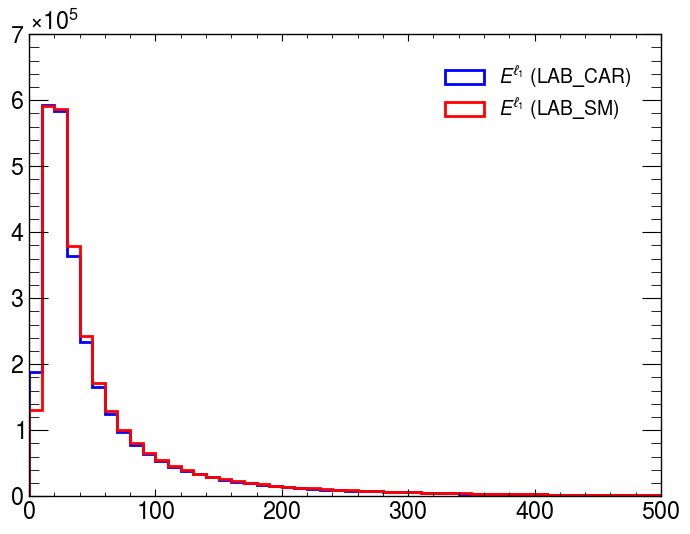

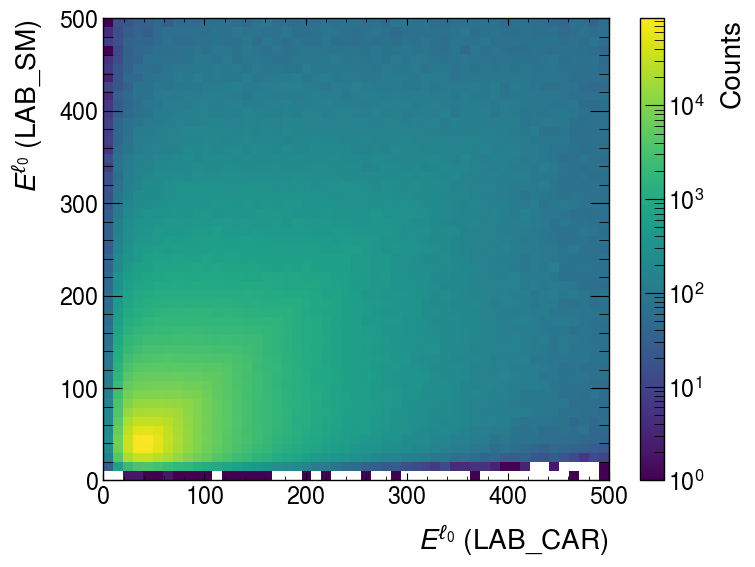

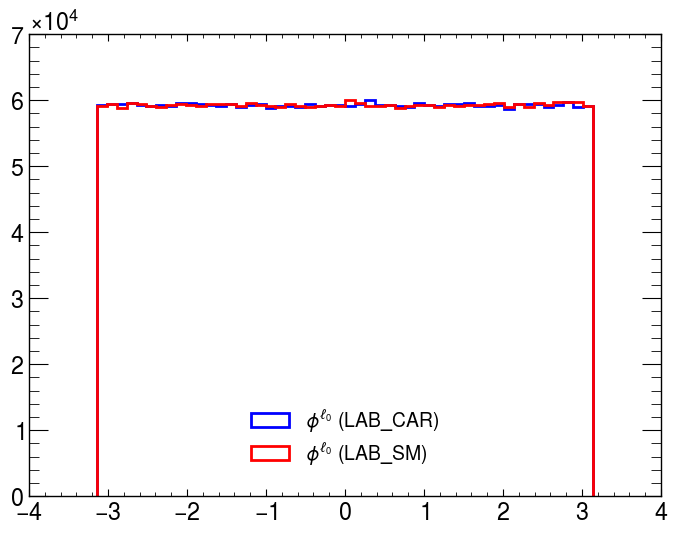

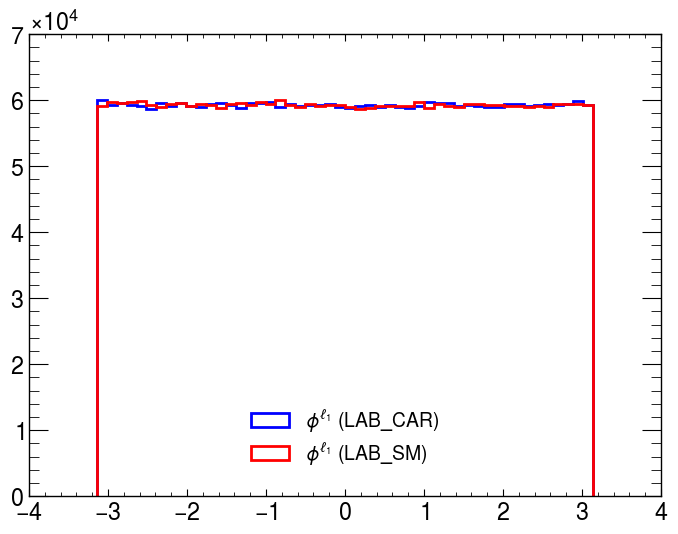

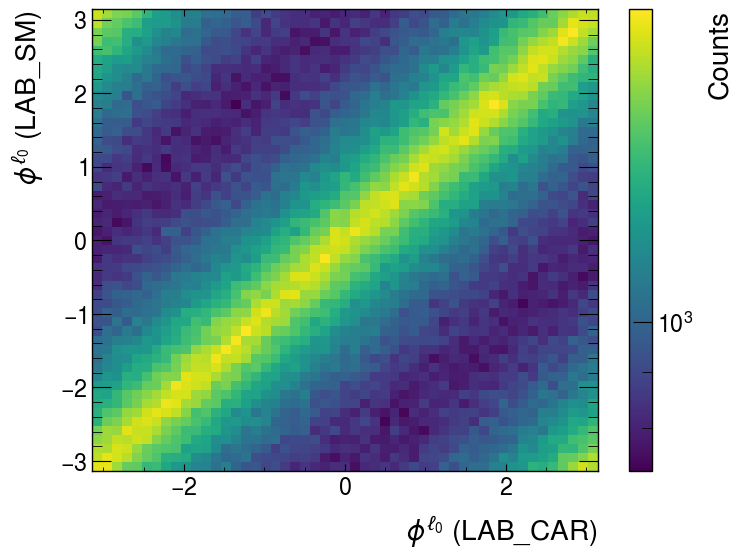

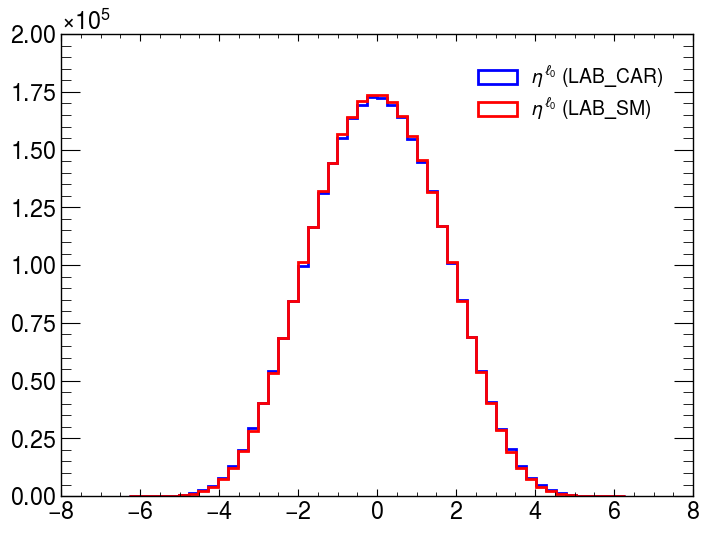

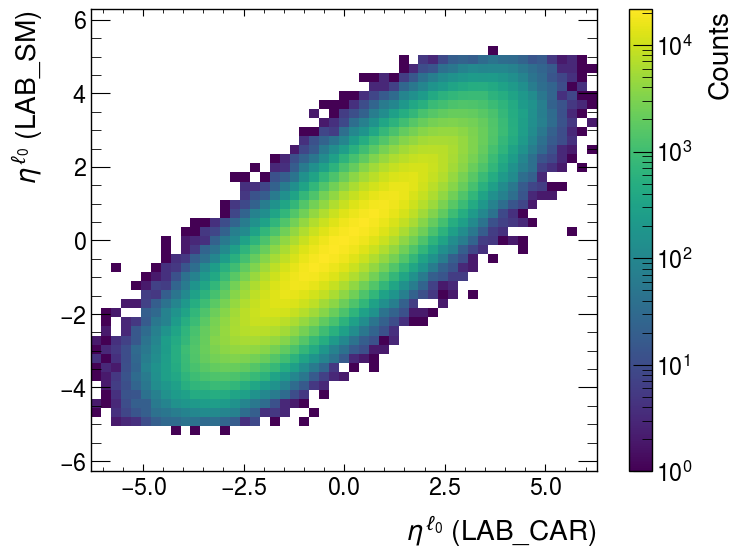

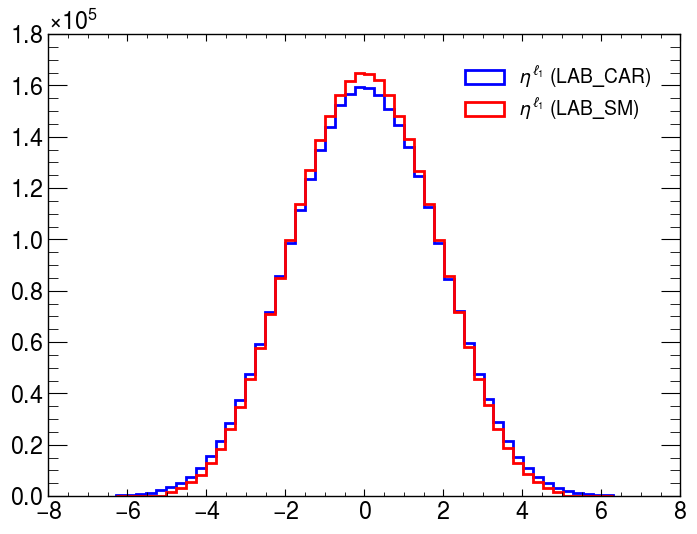

In [19]:
# Lepton kinematics in the lab frame

# Define plotting configs for each variable
plot_configs = [
    {
        "idx": 0, "range": (-100, 100), "label": r"$p_x$", "xlabel": r"$p_x$", "unit": "GeV"
    },
    {
        "idx": 2, "range": (-500, 500), "label": r"$p_z$", "xlabel": r"$p_z$", "unit": "GeV"
    },
    {
        "idx": 3, "range": (0, 500), "label": r"$E$", "xlabel": r"$E$", "unit": "GeV"
    }
]

for cfg in plot_configs:
    bins_edges = np.linspace(cfg["range"][0], cfg["range"][1], 51)
    # l0
    plt.hist(truth_lab_lp_car[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_0}}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
    plt.hist(truth_lab_lp[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_0}}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
    plt.legend()
    plt.show()
    # l1
    plt.hist(truth_lab_ln_car[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_1}}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
    plt.hist(truth_lab_ln[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_1}}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
    plt.legend()
    plt.show()
    # 2D (l0 only)
    plt.hist2d(truth_lab_lp_car[:,cfg["idx"]], truth_lab_lp[:,cfg["idx"]], bins=51, range=[cfg["range"],cfg["range"]], cmap='viridis', cmin=1, norm=LogNorm())
    plt.colorbar(label='Counts', norm=LogNorm())
    plt.xlabel(fr"{cfg['label']}$^{{\ell_0}}$ (LAB_CAR)")
    plt.ylabel(fr"{cfg['label']}$^{{\ell_0}}$ (LAB_SM)")
    plt.show()

# phi
bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_car = phi(truth_lab_lp_car[:,0], truth_lab_lp_car[:,1])
lp_phi = phi(truth_lab_lp[:,0], truth_lab_lp[:,1])
plt.hist(lp_phi_car, bins=bins_edges, label=r"$\phi^{\ell_0}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell_0}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
ln_phi_car = phi(truth_lab_ln_car[:,0], truth_lab_ln_car[:,1])
ln_phi = phi(truth_lab_ln[:,0], truth_lab_ln[:,1])
plt.hist(ln_phi_car, bins=bins_edges, label=r"$\phi^{\ell_1}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell_1}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
plt.hist2d(lp_phi_car, lp_phi, bins=51, range=[(-np.pi,np.pi),(-np.pi,np.pi)], cmap='viridis', cmin=1, norm=LogNorm())
plt.colorbar(label='Counts', norm=LogNorm())
plt.xlabel(r"$\phi^{\ell_0}$ (LAB_CAR)")
plt.ylabel(r"$\phi^{\ell_0}$ (LAB_SM)")
plt.show()

# eta
bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_car = eta(truth_lab_lp_car[:,0], truth_lab_lp_car[:,1], truth_lab_lp_car[:,2])
lp_eta = eta(truth_lab_lp[:,0], truth_lab_lp[:,1], truth_lab_lp[:,2])
plt.hist(lp_eta_car, bins=bins_edges, label=r"$\eta^{\ell_0}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell_0}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
plt.hist2d(lp_eta_car, lp_eta, bins=51, range=[(-2*np.pi,2*np.pi),(-2*np.pi,2*np.pi)], cmap='viridis', cmin=1, norm=LogNorm())
plt.colorbar(label='Counts', norm=LogNorm())
plt.xlabel(r"$\eta^{\ell_0}$ (LAB_CAR)")
plt.ylabel(r"$\eta^{\ell_0}$ (LAB_SM)")
plt.show()
ln_eta_car = eta(truth_lab_ln_car[:,0], truth_lab_ln_car[:,1], truth_lab_ln_car[:,2])
ln_eta = eta(truth_lab_ln[:,0], truth_lab_ln[:,1], truth_lab_ln[:,2])
plt.hist(ln_eta_car, bins=bins_edges, label=r"$\eta^{\ell_1}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell_1}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()

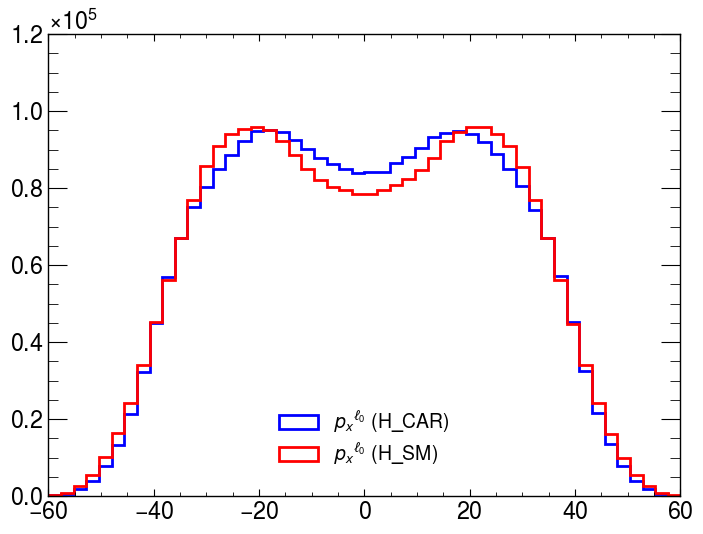

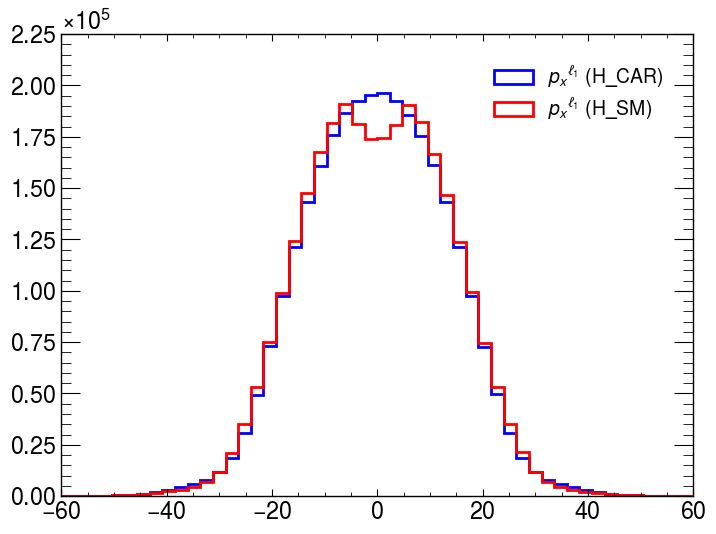

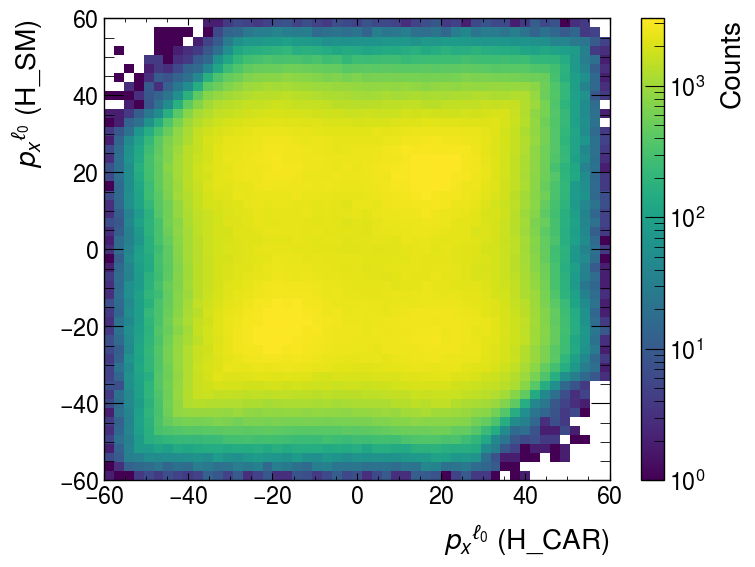

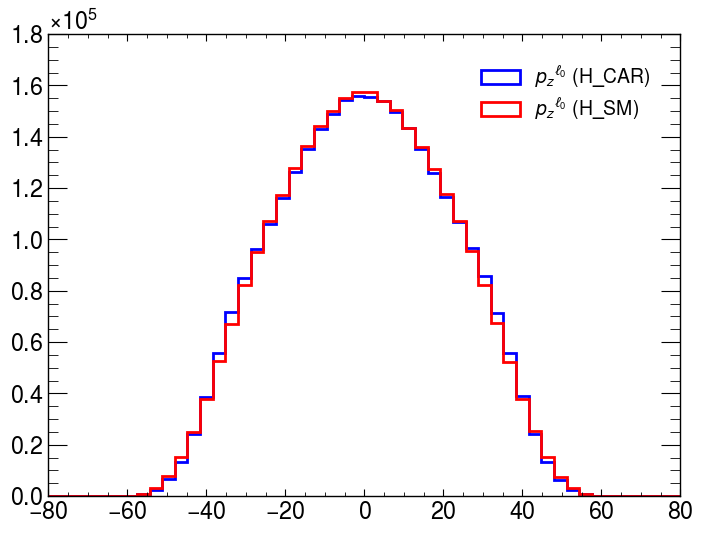

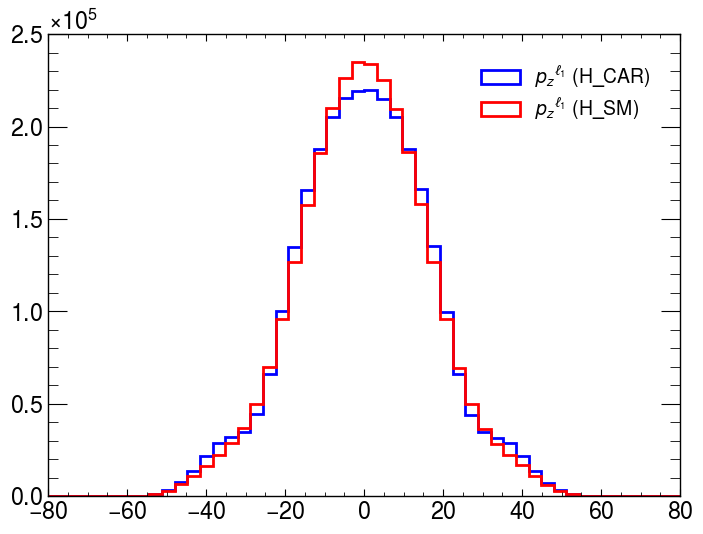

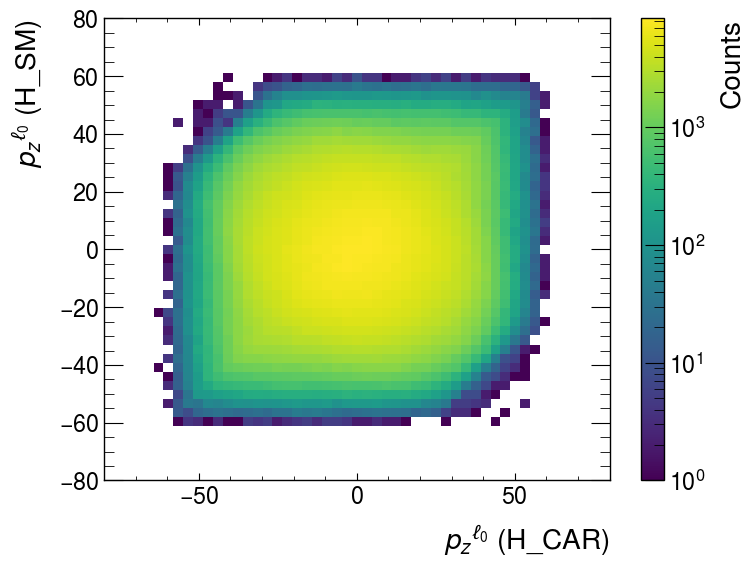

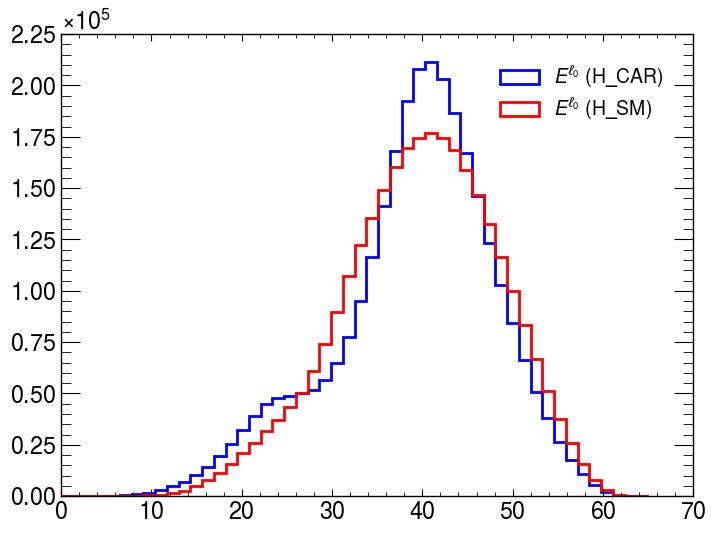

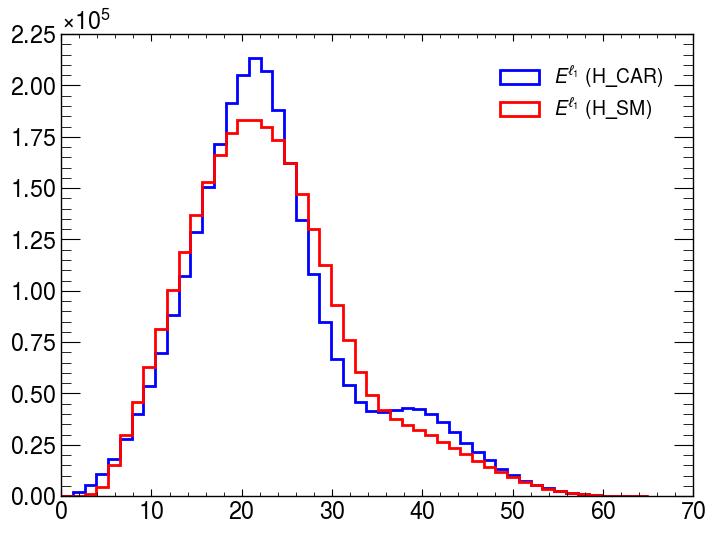

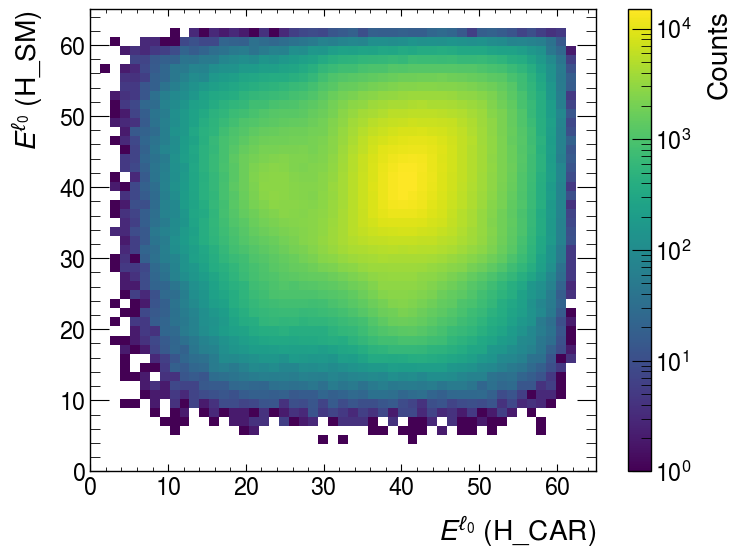

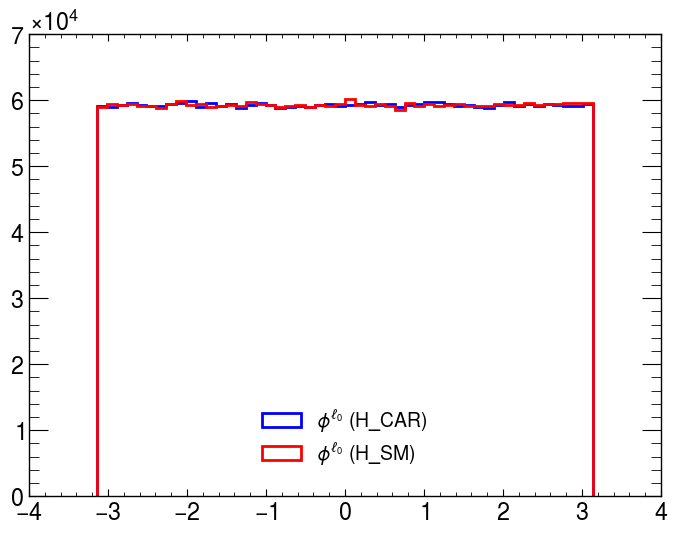

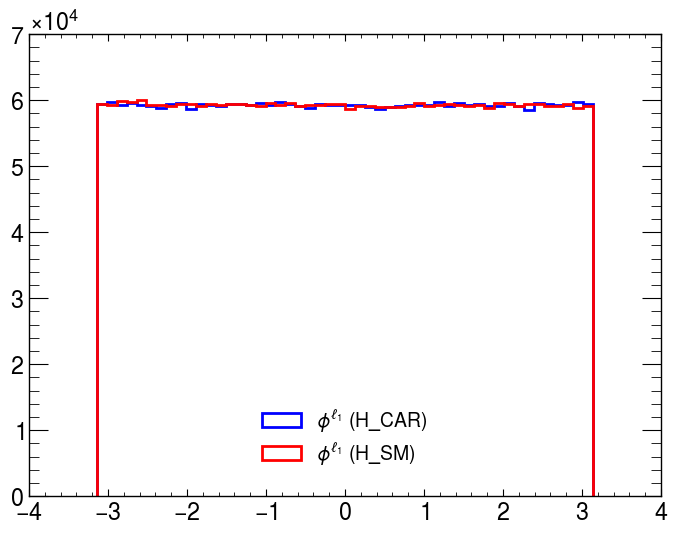

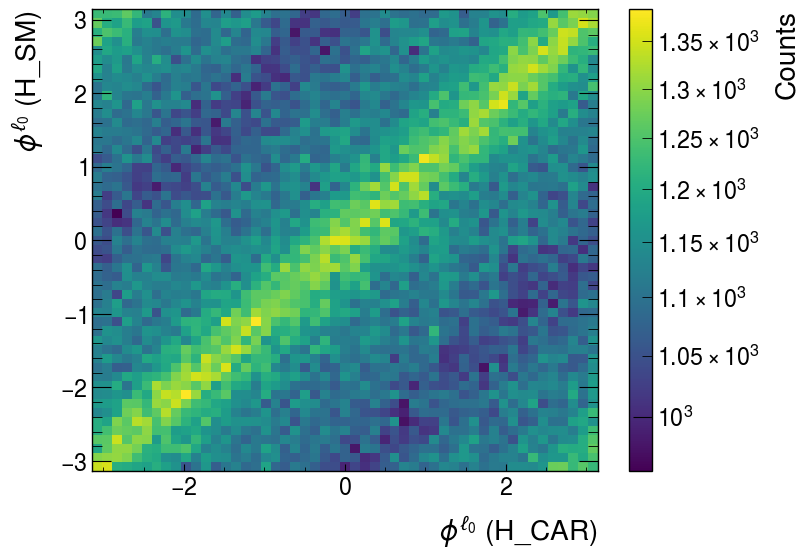

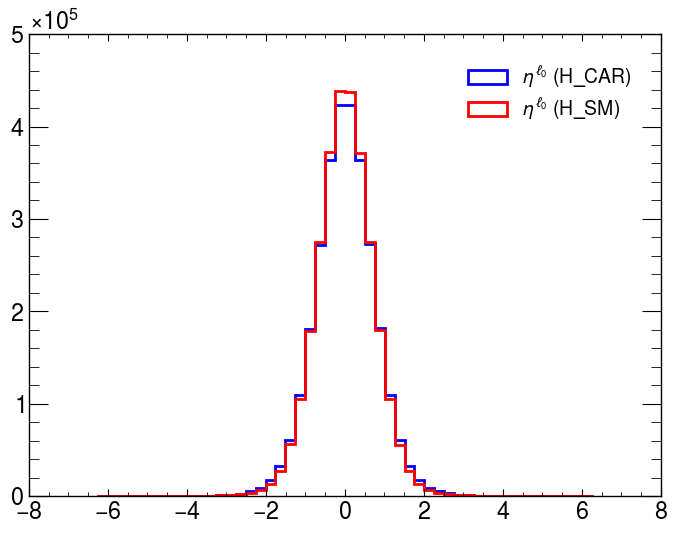

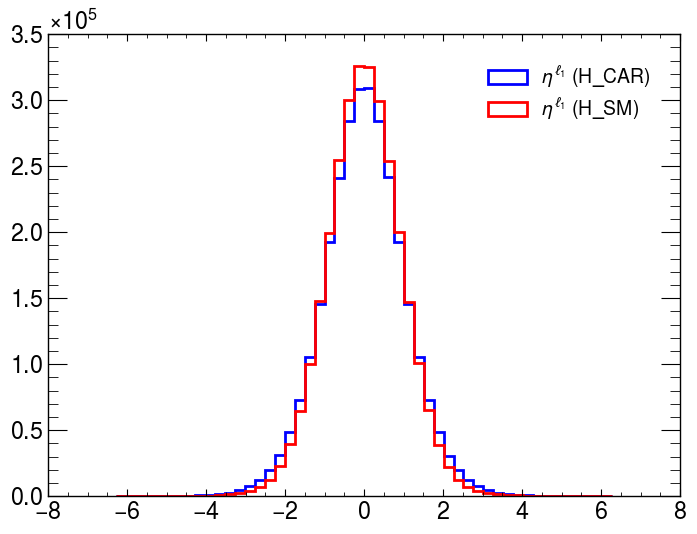

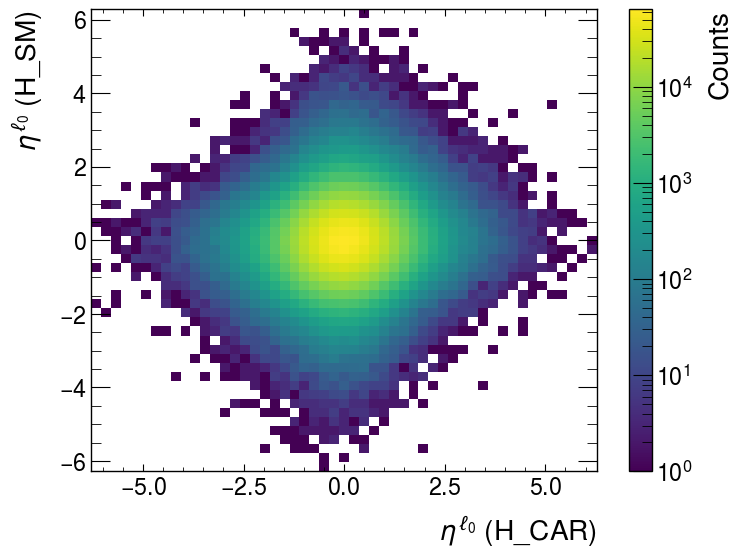

In [20]:
# Lepton kinematics in the Higgs rest frame
# Define plotting configs for each variable in the Higgs rest frame
plot_configs = [
    {
        "idx": 0, "range": (-60, 60), "label": r"$p_x$", "xlabel": r"$p_x$", "unit": "GeV"
    },
    {
        "idx": 2, "range": (-80, 80), "label": r"$p_z$", "xlabel": r"$p_z$", "unit": "GeV"
    },
    {
        "idx": 3, "range": (0, 65), "label": r"$E$", "xlabel": r"$E$", "unit": "GeV"
    }
]

for cfg in plot_configs:
    bins_edges = np.linspace(cfg["range"][0], cfg["range"][1], 51)
    # l0
    plt.hist(truth_h_rest_lp_car[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_0}}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
    plt.hist(truth_h_rest_lp[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_0}}$ (H_SM)", histtype="step", linewidth=2, color="red")
    plt.legend()
    plt.show()
    # l1
    plt.hist(truth_h_rest_ln_car[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_1}}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
    plt.hist(truth_h_rest_ln[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_1}}$ (H_SM)", histtype="step", linewidth=2, color="red")
    plt.legend()
    plt.show()
    # 2D (l0 only)
    plt.hist2d(truth_h_rest_lp_car[:,cfg["idx"]], truth_h_rest_lp[:,cfg["idx"]], bins=51, range=[cfg["range"],cfg["range"]], cmap='viridis', cmin=1, norm=LogNorm())
    plt.colorbar(label='Counts', norm=LogNorm())
    plt.xlabel(fr"{cfg['label']}$^{{\ell_0}}$ (H_CAR)")
    plt.ylabel(fr"{cfg['label']}$^{{\ell_0}}$ (H_SM)")
    plt.show()

# phi
bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_car = phi(truth_h_rest_lp_car[:,0], truth_h_rest_lp_car[:,1])
lp_phi = phi(truth_h_rest_lp[:,0], truth_h_rest_lp[:,1])
plt.hist(lp_phi_car, bins=bins_edges, label=r"$\phi^{\ell_0}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell_0}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
ln_phi_car = phi(truth_h_rest_ln_car[:,0], truth_h_rest_ln_car[:,1])
ln_phi = phi(truth_h_rest_ln[:,0], truth_h_rest_ln[:,1])
plt.hist(ln_phi_car, bins=bins_edges, label=r"$\phi^{\ell_1}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell_1}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
# 2D (l0 only)
plt.hist2d(lp_phi_car, lp_phi, bins=51, range=[(-np.pi,np.pi),(-np.pi,np.pi)], cmap='viridis', cmin=1, norm=LogNorm())
plt.colorbar(label='Counts', norm=LogNorm())
plt.xlabel(r"$\phi^{\ell_0}$ (H_CAR)")
plt.ylabel(r"$\phi^{\ell_0}$ (H_SM)")
plt.show()

# eta
bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_car = eta(truth_h_rest_lp_car[:,0], truth_h_rest_lp_car[:,1], truth_h_rest_lp_car[:,2])
lp_eta = eta(truth_h_rest_lp[:,0], truth_h_rest_lp[:,1], truth_h_rest_lp[:,2])
plt.hist(lp_eta_car, bins=bins_edges, label=r"$\eta^{\ell_0}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell_0}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
ln_eta_car = eta(truth_h_rest_ln_car[:,0], truth_h_rest_ln_car[:,1], truth_h_rest_ln_car[:,2])
ln_eta = eta(truth_h_rest_ln[:,0], truth_h_rest_ln[:,1], truth_h_rest_ln[:,2])
plt.hist(ln_eta_car, bins=bins_edges, label=r"$\eta^{\ell_1}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell_1}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
# 2D (l0 only)
plt.hist2d(lp_eta_car, lp_eta, bins=51, range=[(-2*np.pi,2*np.pi),(-2*np.pi,2*np.pi)], cmap='viridis', cmin=1, norm=LogNorm())
plt.colorbar(label='Counts', norm=LogNorm())
plt.xlabel(r"$\eta^{\ell_0}$ (H_CAR)")
plt.ylabel(r"$\eta^{\ell_0}$ (H_SM)")
plt.show()

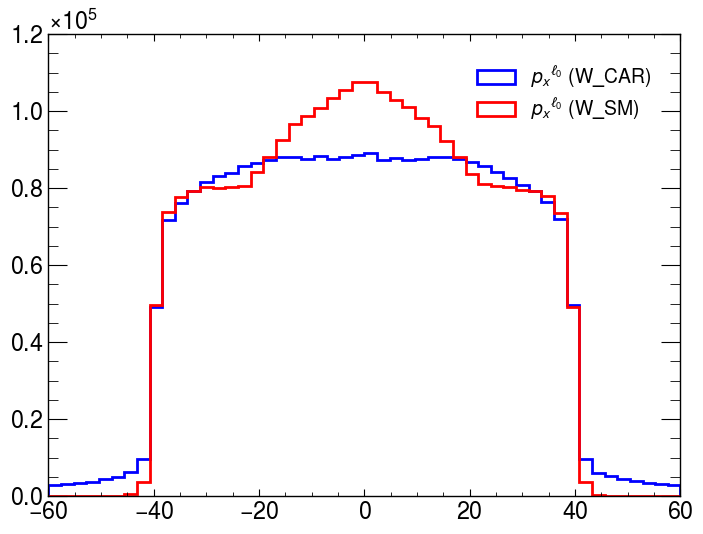

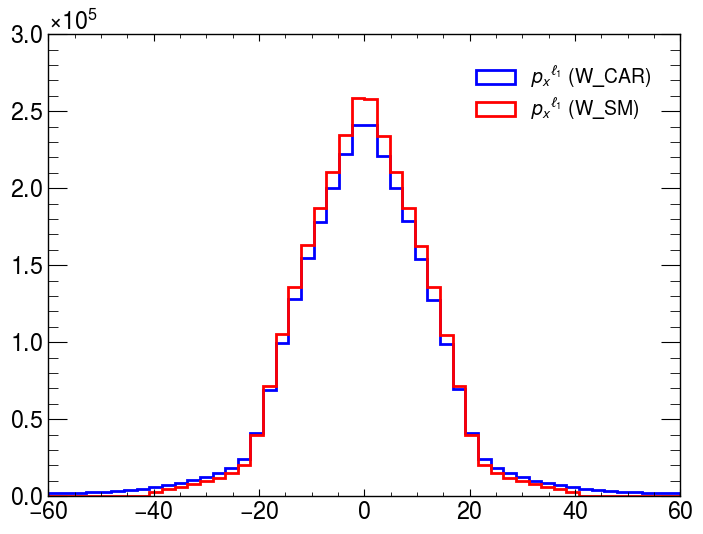

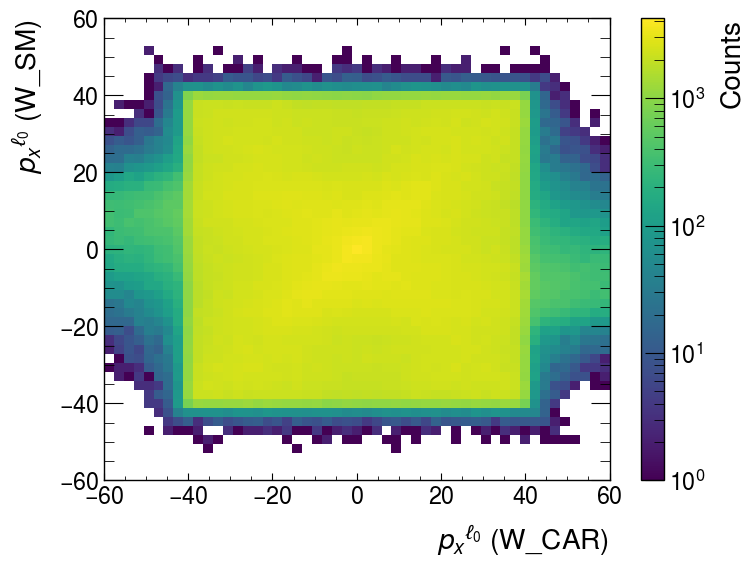

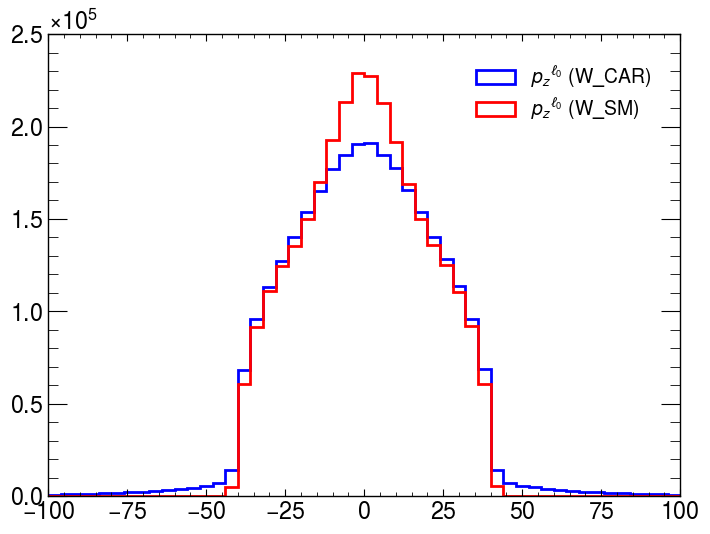

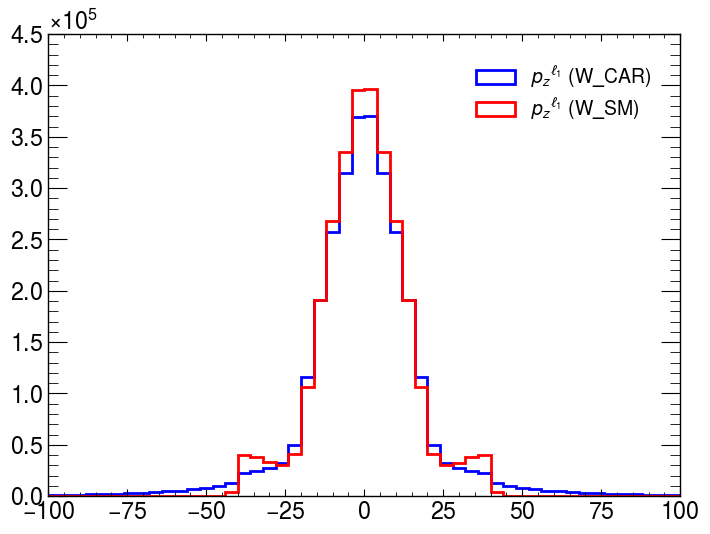

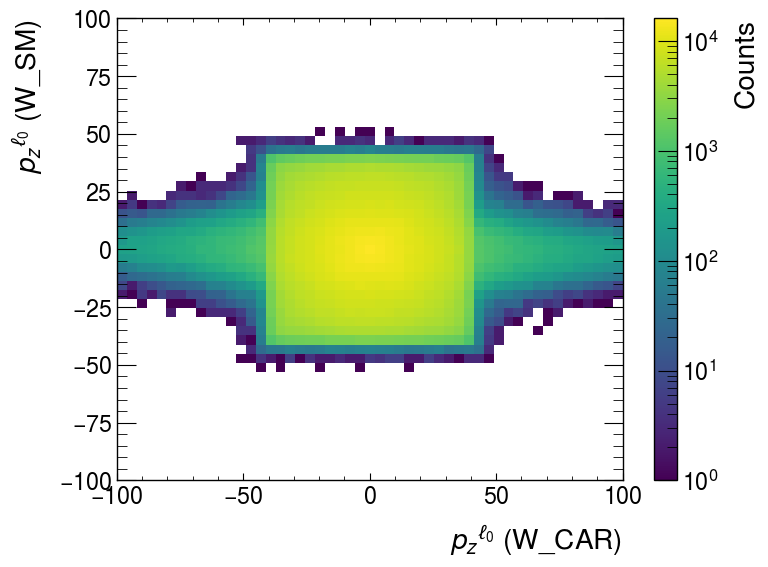

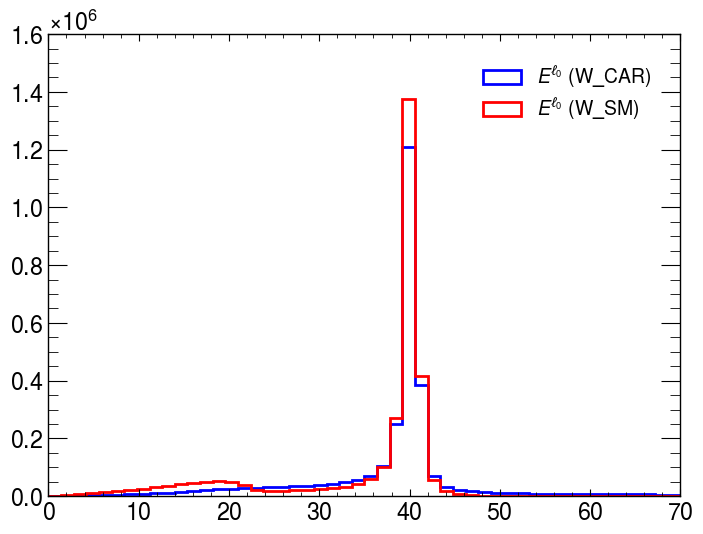

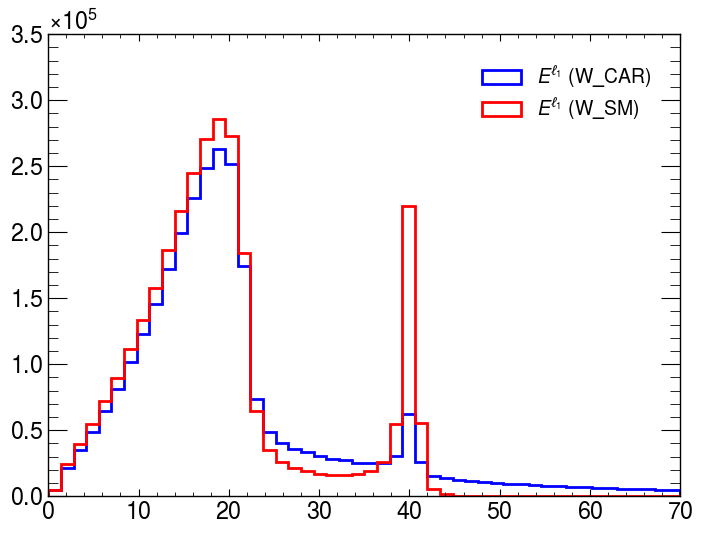

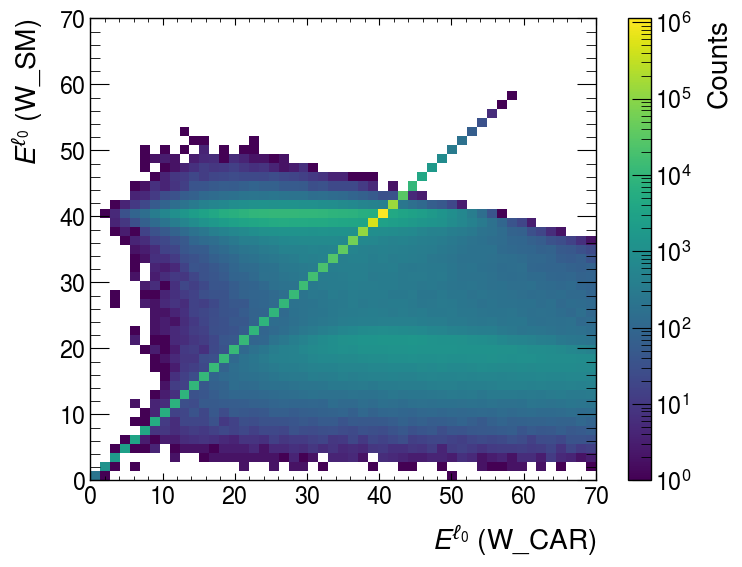

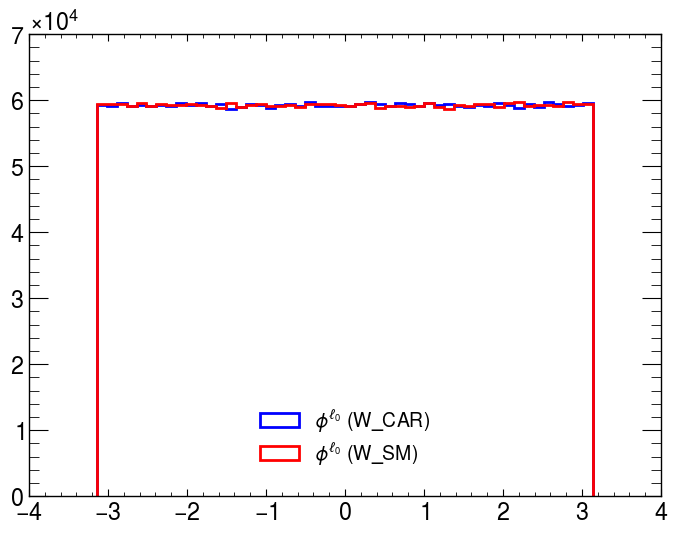

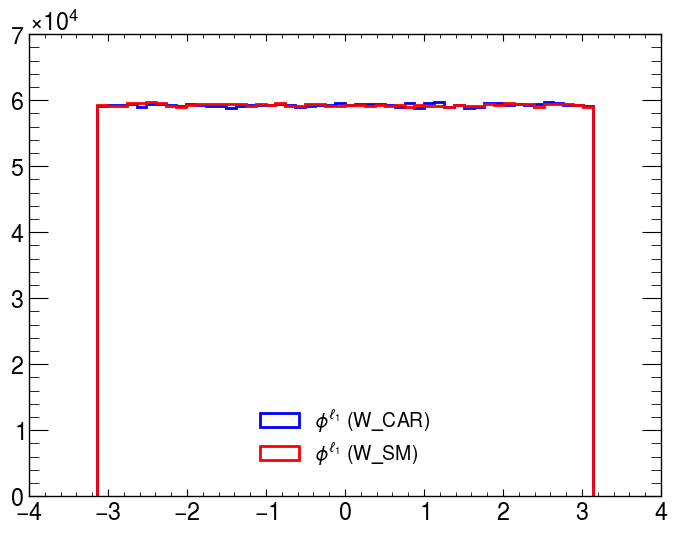

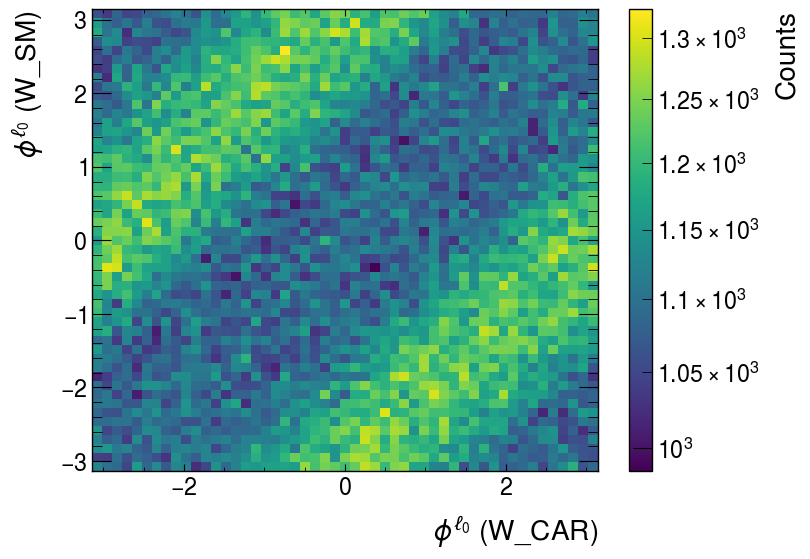

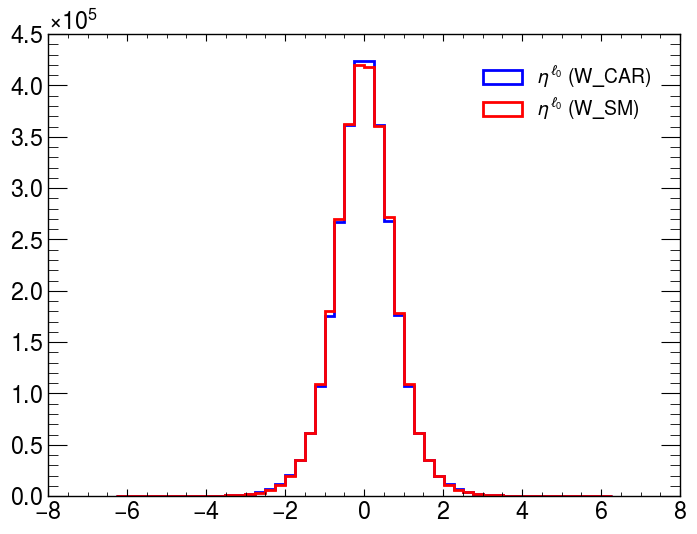

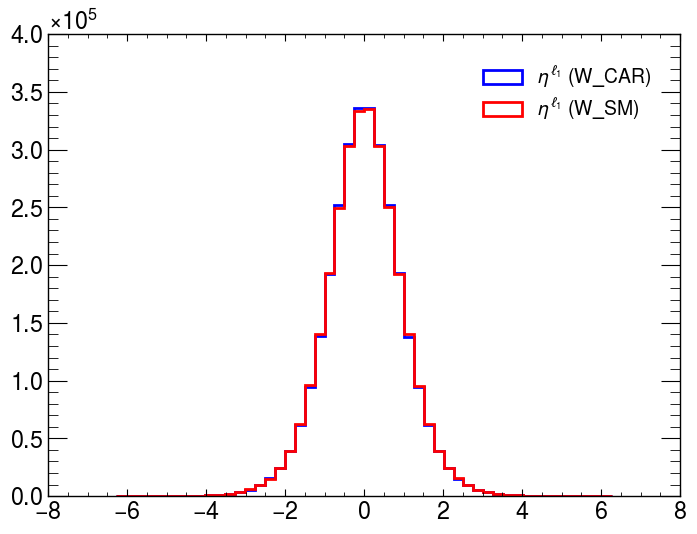

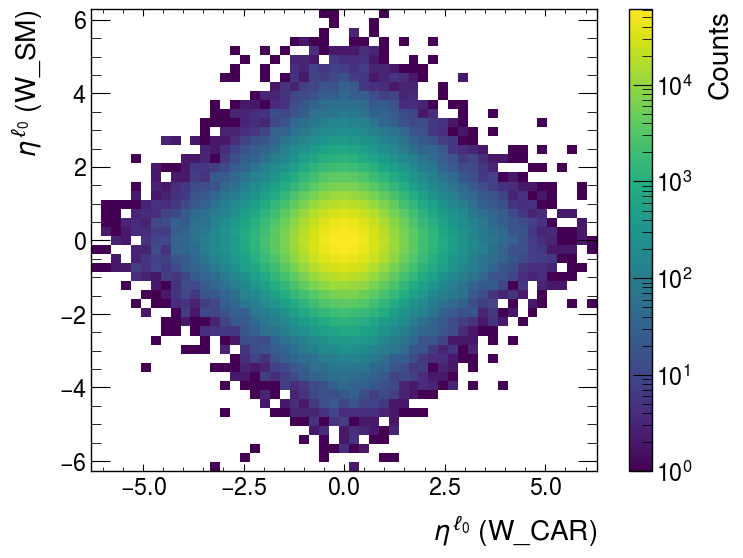

In [21]:
# Lepton kinematics in the Higgs rest frame
# Define plotting configs for each variable in the Higgs rest frame
plot_configs = [
    {
        "idx": 0, "range": (-60, 60), "label": r"$p_x$", "xlabel": r"$p_x$", "unit": "GeV"
    },
    {
        "idx": 2, "range": (-100, 100), "label": r"$p_z$", "xlabel": r"$p_z$", "unit": "GeV"
    },
    {
        "idx": 3, "range": (0, 70), "label": r"$E$", "xlabel": r"$E$", "unit": "GeV"
    }
]

for cfg in plot_configs:
    bins_edges = np.linspace(cfg["range"][0], cfg["range"][1], 51)
    # l0
    plt.hist(truth_w_rest_lp_car[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_0}}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
    plt.hist(truth_w_rest_lp[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_0}}$ (W_SM)", histtype="step", linewidth=2, color="red")
    plt.legend()
    plt.show()
    # l1
    plt.hist(truth_w_rest_ln_car[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_1}}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
    plt.hist(truth_w_rest_ln[:,cfg["idx"]], bins=bins_edges, label=fr"{cfg['label']}$^{{\ell_1}}$ (W_SM)", histtype="step", linewidth=2, color="red")
    plt.legend()
    plt.show()
    # 2D (l0 only)
    plt.hist2d(truth_w_rest_lp_car[:,cfg["idx"]], truth_w_rest_lp[:,cfg["idx"]], bins=51, range=[cfg["range"],cfg["range"]], cmap='viridis', cmin=1, norm=LogNorm())
    plt.colorbar(label='Counts', norm=LogNorm())
    plt.xlabel(fr"{cfg['label']}$^{{\ell_0}}$ (W_CAR)")
    plt.ylabel(fr"{cfg['label']}$^{{\ell_0}}$ (W_SM)")
    plt.show()

# phi
bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_car = phi(truth_w_rest_lp_car[:,0], truth_w_rest_lp_car[:,1])
lp_phi = phi(truth_w_rest_lp[:,0], truth_w_rest_lp[:,1])
plt.hist(lp_phi_car, bins=bins_edges, label=r"$\phi^{\ell_0}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell_0}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
ln_phi_car = phi(truth_w_rest_ln_car[:,0], truth_w_rest_ln_car[:,1])
ln_phi = phi(truth_w_rest_ln[:,0], truth_w_rest_ln[:,1])
plt.hist(ln_phi_car, bins=bins_edges, label=r"$\phi^{\ell_1}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell_1}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
# 2D (l0 only)
plt.hist2d(lp_phi_car, lp_phi, bins=51, range=[(-np.pi,np.pi),(-np.pi,np.pi)], cmap='viridis', cmin=1, norm=LogNorm())
plt.colorbar(label='Counts', norm=LogNorm())
plt.xlabel(r"$\phi^{\ell_0}$ (W_CAR)")
plt.ylabel(r"$\phi^{\ell_0}$ (W_SM)")
plt.show()

# eta
bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_car = eta(truth_w_rest_lp_car[:,0], truth_w_rest_lp_car[:,1], truth_w_rest_lp_car[:,2])
lp_eta = eta(truth_w_rest_lp[:,0], truth_w_rest_lp[:,1], truth_w_rest_lp[:,2])
plt.hist(lp_eta_car, bins=bins_edges, label=r"$\eta^{\ell_0}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell_0}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
ln_eta_car = eta(truth_w_rest_ln_car[:,0], truth_w_rest_ln_car[:,1], truth_w_rest_ln_car[:,2])
ln_eta = eta(truth_w_rest_ln[:,0], truth_w_rest_ln[:,1], truth_w_rest_ln[:,2])
plt.hist(ln_eta_car, bins=bins_edges, label=r"$\eta^{\ell_1}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell_1}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
# 2D (l0 only)
plt.hist2d(lp_eta_car, lp_eta, bins=51, range=[(-2*np.pi,2*np.pi),(-2*np.pi,2*np.pi)], cmap='viridis', cmin=1, norm=LogNorm())
plt.colorbar(label='Counts', norm=LogNorm())
plt.xlabel(r"$\eta^{\ell_0}$ (W_CAR)")
plt.ylabel(r"$\eta^{\ell_0}$ (W_SM)")
plt.show()

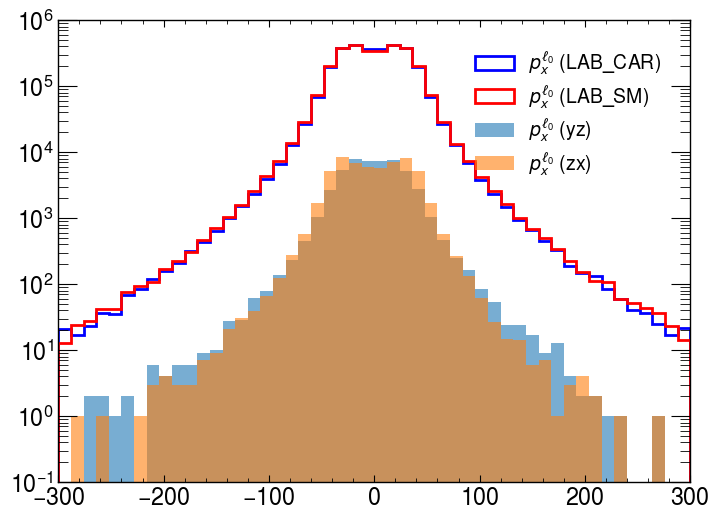

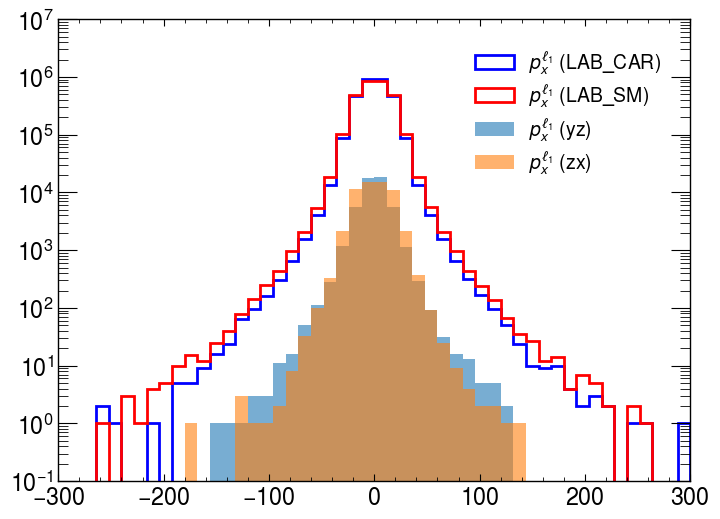

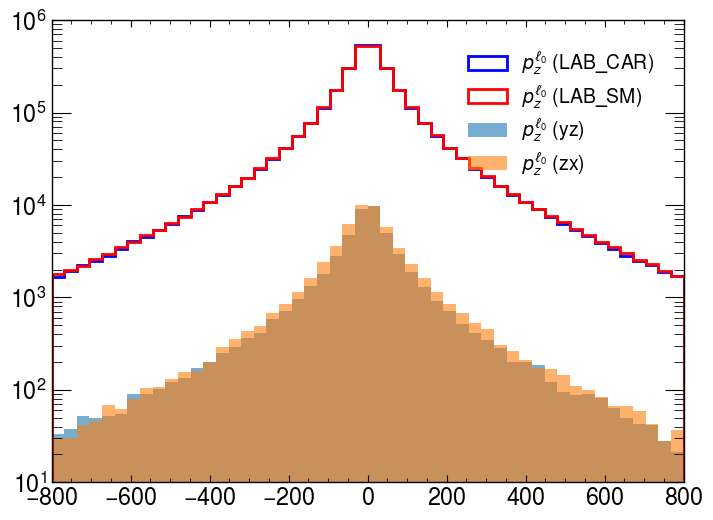

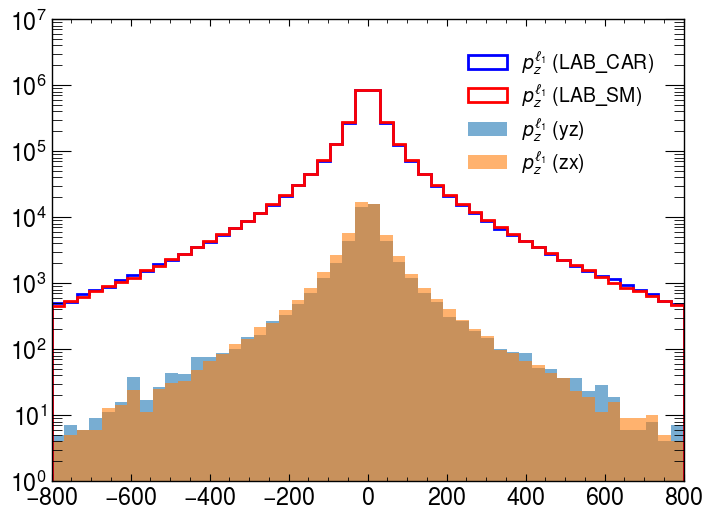

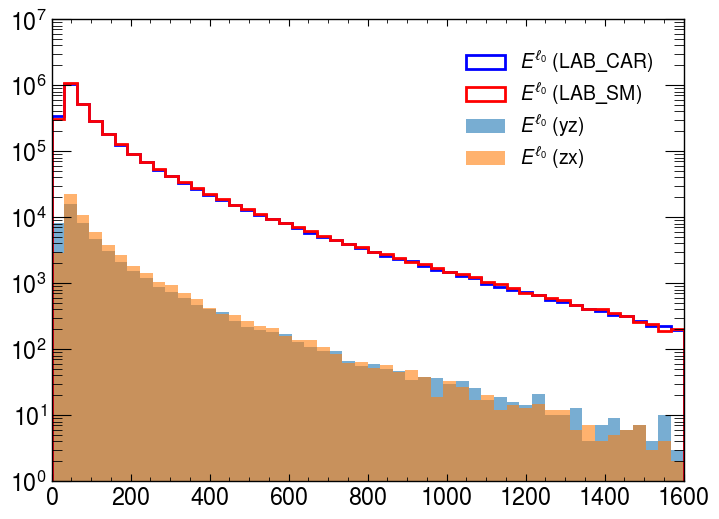

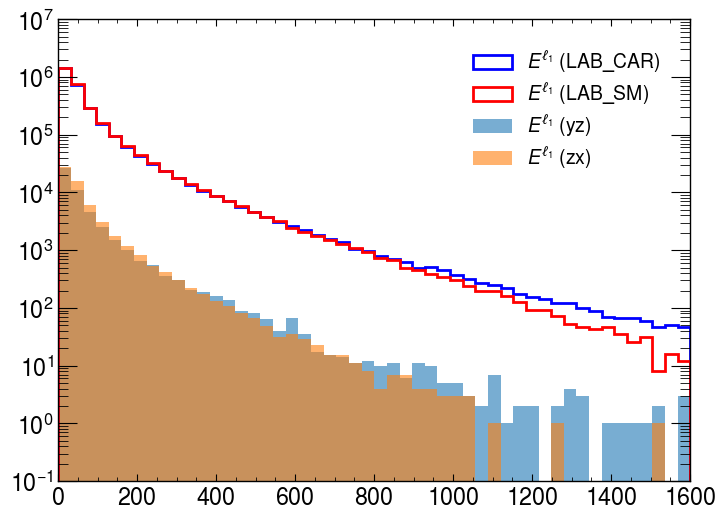

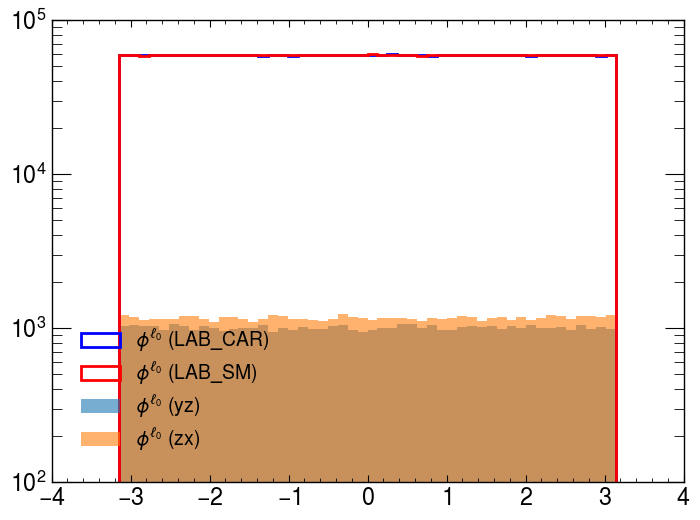

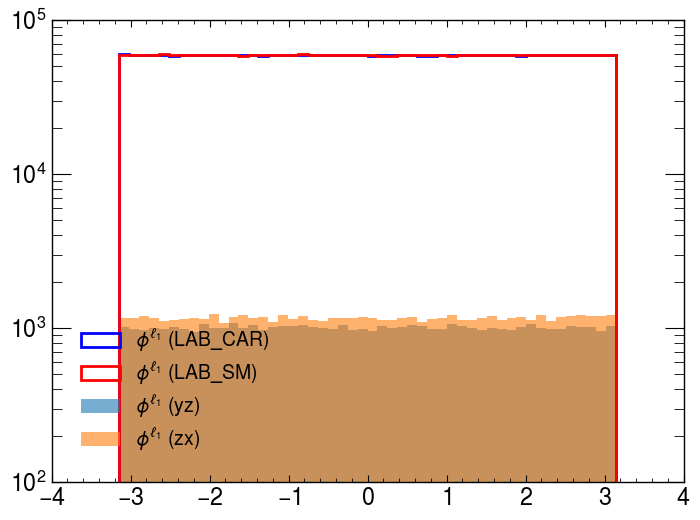

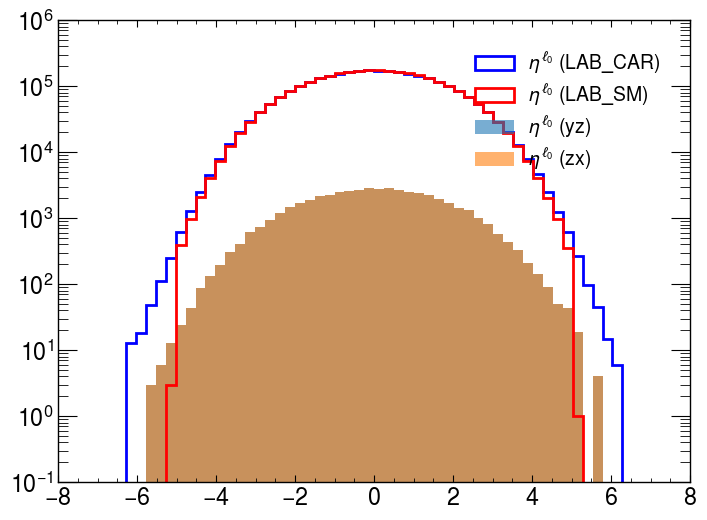

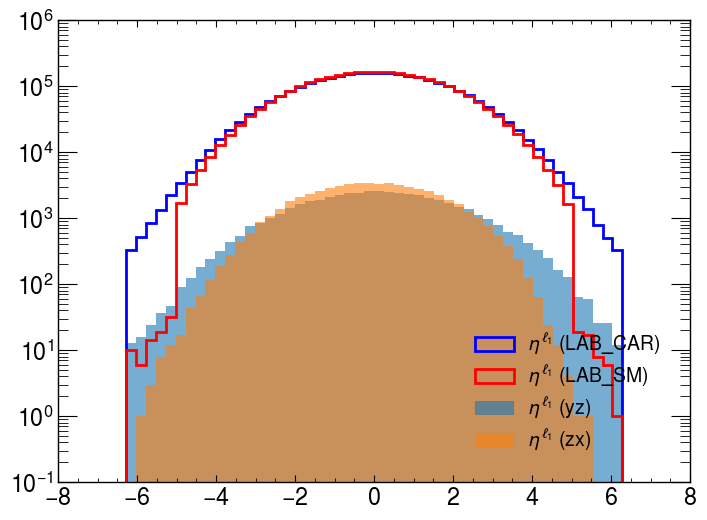

In [22]:
# lepton kinametics in the Higgs rest frame (tagging)

bins_edges = np.linspace(-300, 300, 51)
plt.hist(truth_lab_lp_car[:,0], bins=bins_edges, label=r"$p_x^{\ell_0}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lab_lp[:,0], bins=bins_edges, label=r"$p_x^{\ell_0}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_lab_lp_car[:,0][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_x^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_lab_lp_car[:,0][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_x^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_lab_ln_car[:,0], bins=bins_edges, label=r"$p_x^{\ell_1}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lab_ln[:,0], bins=bins_edges, label=r"$p_x^{\ell_1}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_lab_ln_car[:,0][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_x^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_lab_ln_car[:,0][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_x^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-800, 800, 51)
plt.hist(truth_lab_lp_car[:,2], bins=bins_edges, label=r"$p_z^{\ell_0}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lab_lp[:,2], bins=bins_edges, label=r"$p_z^{\ell_0}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_lab_lp_car[:,2][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_z^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_lab_lp_car[:,2][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_z^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_lab_ln_car[:,2], bins=bins_edges, label=r"$p_z^{\ell_1}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lab_ln[:,2], bins=bins_edges, label=r"$p_z^{\ell_1}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_lab_ln_car[:,2][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_z^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_lab_ln_car[:,2][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_z^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(0, 1600, 51)
plt.hist(truth_lab_lp_car[:,3], bins=bins_edges, label=r"$E^{\ell_0}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lab_lp[:,3], bins=bins_edges, label=r"$E^{\ell_0}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_lab_lp_car[:,3][truth_bij_car_yz_mask], bins=bins_edges, label=r"$E^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_lab_lp_car[:,3][truth_bij_car_zx_mask], bins=bins_edges, label=r"$E^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_lab_ln_car[:,3], bins=bins_edges, label=r"$E^{\ell_1}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lab_ln[:,3], bins=bins_edges, label=r"$E^{\ell_1}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_lab_ln_car[:,3][truth_bij_car_yz_mask], bins=bins_edges, label=r"$E^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_lab_ln_car[:,3][truth_bij_car_zx_mask], bins=bins_edges, label=r"$E^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_car = phi(truth_lab_lp_car[:,0], truth_lab_lp_car[:,1])
lp_phi = phi(truth_lab_lp[:,0], truth_lab_lp[:,1])
plt.hist(lp_phi_car, bins=bins_edges, label=r"$\phi^{\ell_0}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell_0}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(lp_phi_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\phi^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(lp_phi_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\phi^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
ln_phi_car = phi(truth_lab_ln_car[:,0], truth_lab_ln_car[:,1])
ln_phi = phi(truth_lab_ln[:,0], truth_lab_ln[:,1])
plt.hist(ln_phi_car, bins=bins_edges, label=r"$\phi^{\ell_1}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell_1}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(ln_phi_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\phi^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(ln_phi_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\phi^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_car = eta(truth_lab_lp_car[:,0], truth_lab_lp_car[:,1], truth_lab_lp_car[:,2])
lp_eta = eta(truth_lab_lp[:,0], truth_lab_lp[:,1], truth_lab_lp[:,2])
plt.hist(lp_eta_car, bins=bins_edges, label=r"$\eta^{\ell_0}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell_0}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(lp_eta_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\eta^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(lp_eta_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\eta^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
ln_eta_car = eta(truth_lab_ln_car[:,0], truth_lab_ln_car[:,1], truth_lab_ln_car[:,2])
ln_eta = eta(truth_lab_ln[:,0], truth_lab_ln[:,1], truth_lab_ln[:,2])
plt.hist(ln_eta_car, bins=bins_edges, label=r"$\eta^{\ell_1}$ (LAB_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell_1}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(ln_eta_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\eta^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(ln_eta_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\eta^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

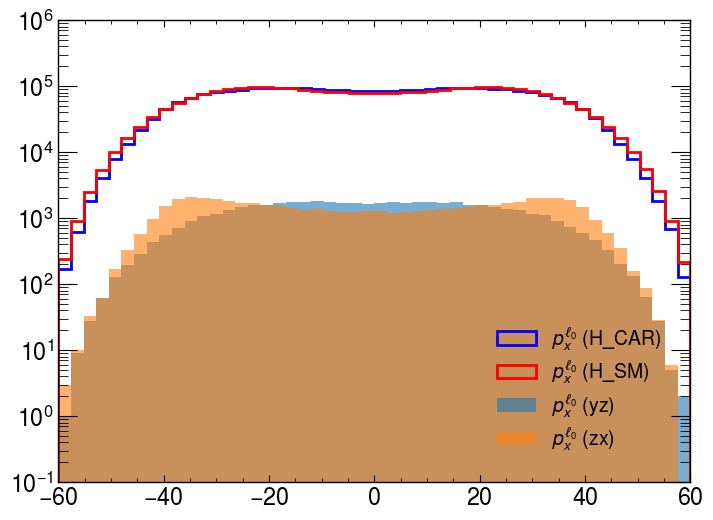

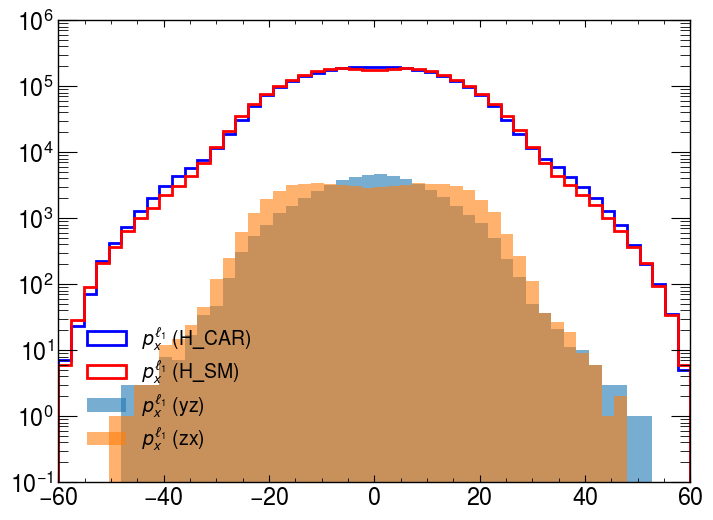

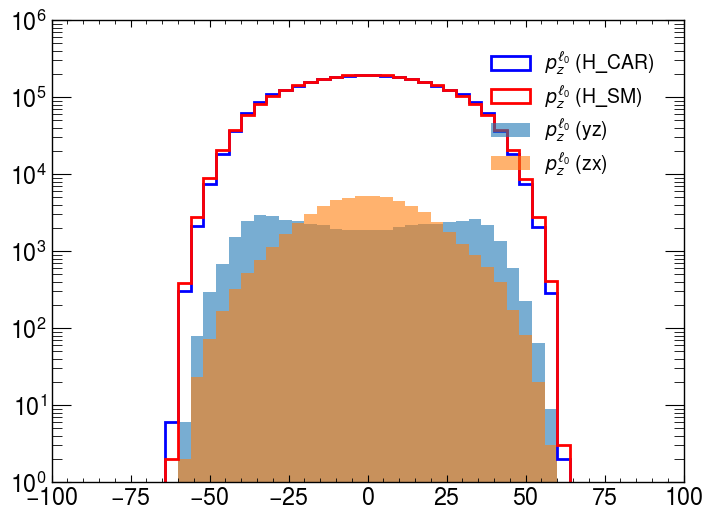

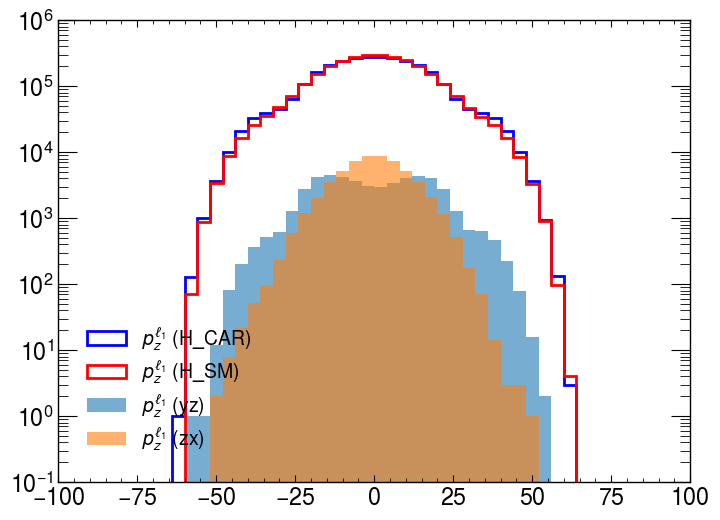

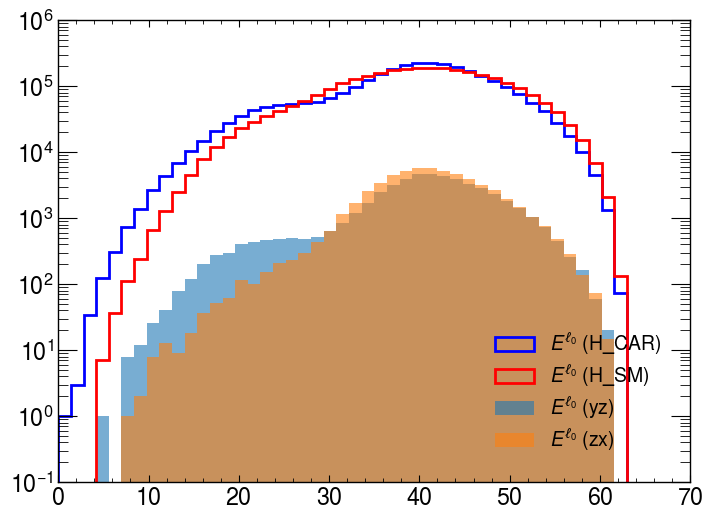

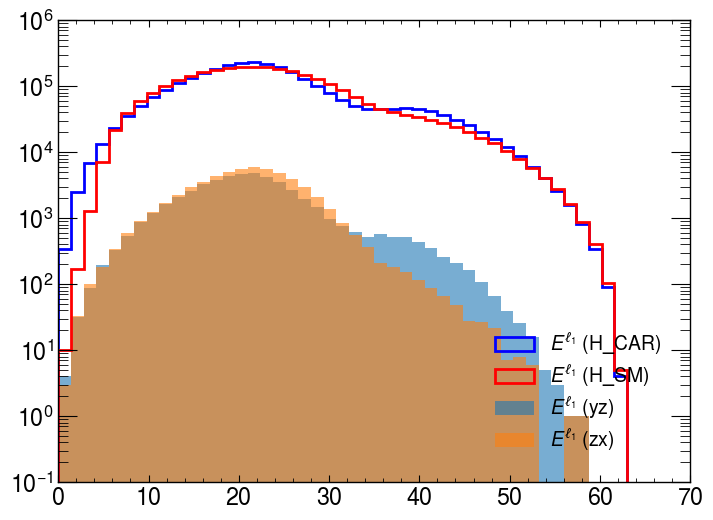

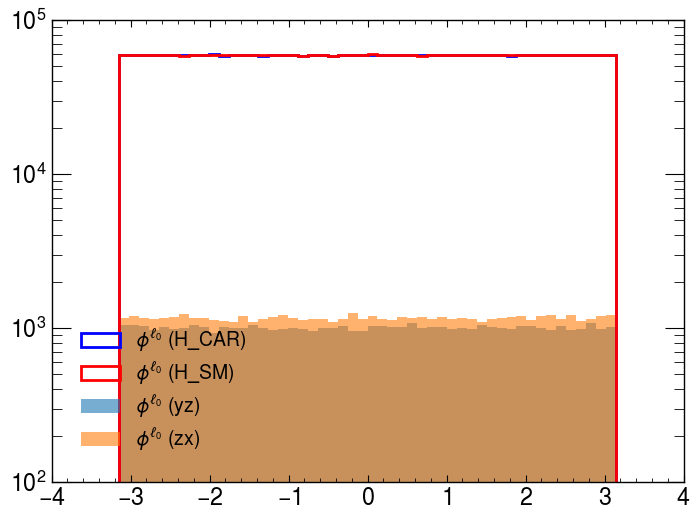

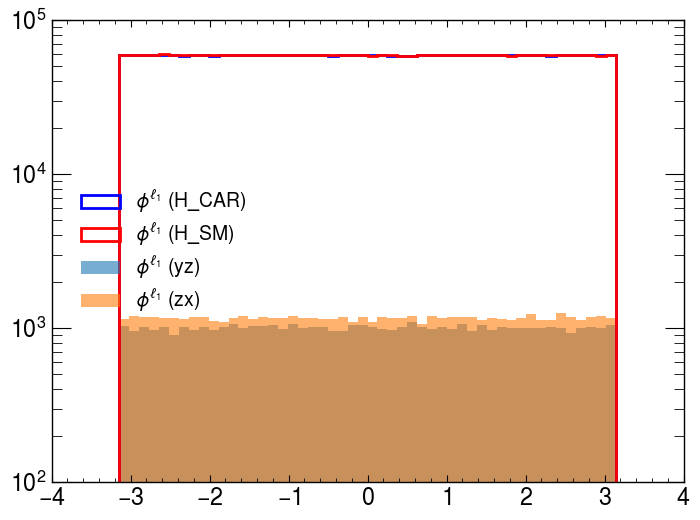

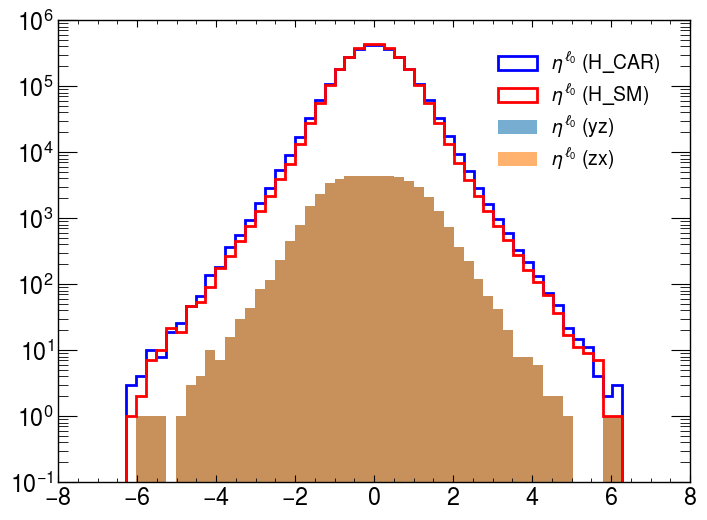

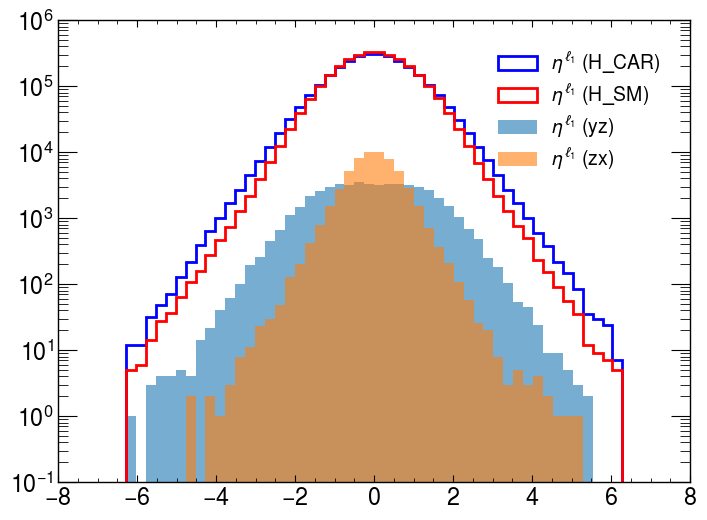

In [23]:
# lepton kinametics in the Higgs rest frame (tagging)

bins_edges = np.linspace(-60, 60, 51)
plt.hist(truth_h_rest_lp_car[:,0], bins=bins_edges, label=r"$p_x^{\ell_0}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_h_rest_lp[:,0], bins=bins_edges, label=r"$p_x^{\ell_0}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_h_rest_lp_car[:,0][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_x^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_h_rest_lp_car[:,0][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_x^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_h_rest_ln_car[:,0], bins=bins_edges, label=r"$p_x^{\ell_1}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_h_rest_ln[:,0], bins=bins_edges, label=r"$p_x^{\ell_1}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_h_rest_ln_car[:,0][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_x^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_h_rest_ln_car[:,0][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_x^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-100, 100, 51)
plt.hist(truth_h_rest_lp_car[:,2], bins=bins_edges, label=r"$p_z^{\ell_0}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_h_rest_lp[:,2], bins=bins_edges, label=r"$p_z^{\ell_0}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_h_rest_lp_car[:,2][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_z^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_h_rest_lp_car[:,2][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_z^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_h_rest_ln_car[:,2], bins=bins_edges, label=r"$p_z^{\ell_1}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_h_rest_ln[:,2], bins=bins_edges, label=r"$p_z^{\ell_1}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_h_rest_ln_car[:,2][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_z^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_h_rest_ln_car[:,2][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_z^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(0, 70, 51)
plt.hist(truth_h_rest_lp_car[:,3], bins=bins_edges, label=r"$E^{\ell_0}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_h_rest_lp[:,3], bins=bins_edges, label=r"$E^{\ell_0}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_h_rest_lp_car[:,3][truth_bij_car_yz_mask], bins=bins_edges, label=r"$E^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_h_rest_lp_car[:,3][truth_bij_car_zx_mask], bins=bins_edges, label=r"$E^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_h_rest_ln_car[:,3], bins=bins_edges, label=r"$E^{\ell_1}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_h_rest_ln[:,3], bins=bins_edges, label=r"$E^{\ell_1}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_h_rest_ln_car[:,3][truth_bij_car_yz_mask], bins=bins_edges, label=r"$E^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_h_rest_ln_car[:,3][truth_bij_car_zx_mask], bins=bins_edges, label=r"$E^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_car = phi(truth_h_rest_lp_car[:,0], truth_h_rest_lp_car[:,1])
lp_phi = phi(truth_h_rest_lp[:,0], truth_h_rest_lp[:,1])
plt.hist(lp_phi_car, bins=bins_edges, label=r"$\phi^{\ell_0}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell_0}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(lp_phi_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\phi^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(lp_phi_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\phi^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
ln_phi_car = phi(truth_h_rest_ln_car[:,0], truth_h_rest_ln_car[:,1])
ln_phi = phi(truth_h_rest_ln[:,0], truth_h_rest_ln[:,1])
plt.hist(ln_phi_car, bins=bins_edges, label=r"$\phi^{\ell_1}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell_1}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(ln_phi_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\phi^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(ln_phi_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\phi^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_car = eta(truth_h_rest_lp_car[:,0], truth_h_rest_lp_car[:,1], truth_h_rest_lp_car[:,2])
lp_eta = eta(truth_h_rest_lp[:,0], truth_h_rest_lp[:,1], truth_h_rest_lp[:,2])
plt.hist(lp_eta_car, bins=bins_edges, label=r"$\eta^{\ell_0}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell_0}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(lp_eta_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\eta^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(lp_eta_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\eta^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
ln_eta_car = eta(truth_h_rest_ln_car[:,0], truth_h_rest_ln_car[:,1], truth_h_rest_ln_car[:,2])
ln_eta = eta(truth_h_rest_ln[:,0], truth_h_rest_ln[:,1], truth_h_rest_ln[:,2])
plt.hist(ln_eta_car, bins=bins_edges, label=r"$\eta^{\ell_1}$ (H_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell_1}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(ln_eta_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\eta^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(ln_eta_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\eta^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

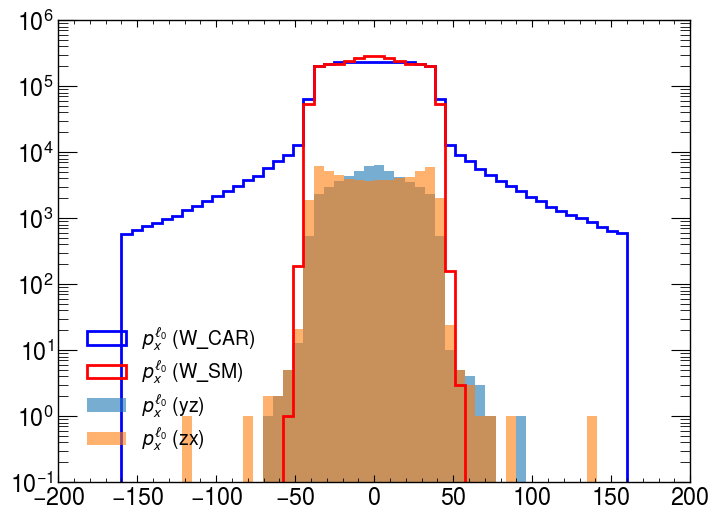

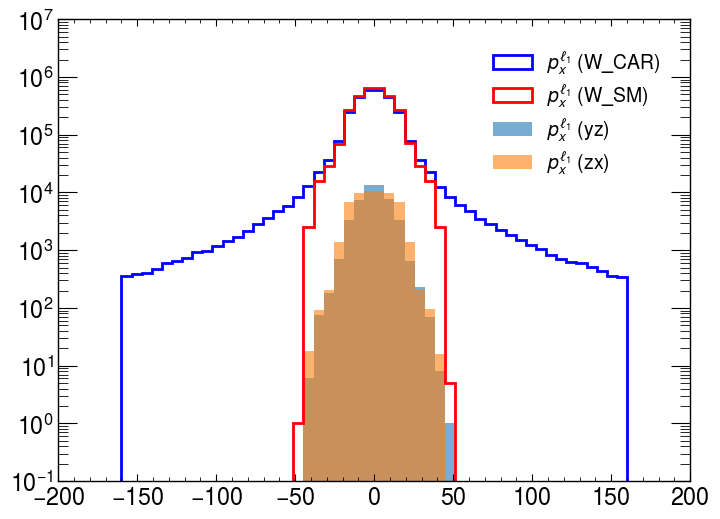

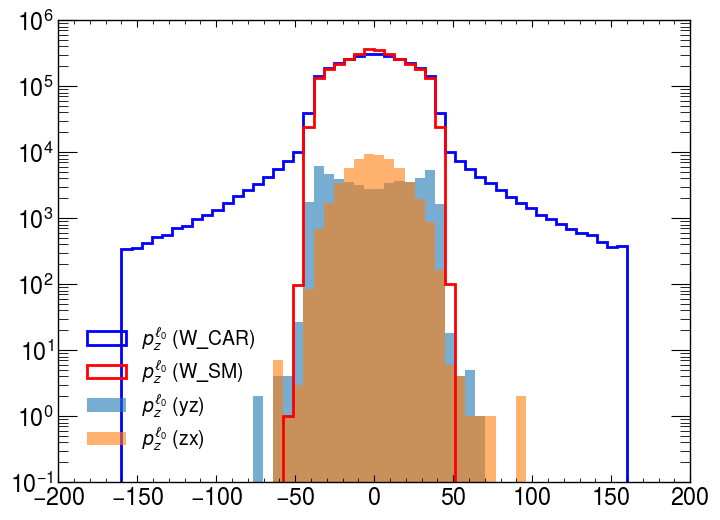

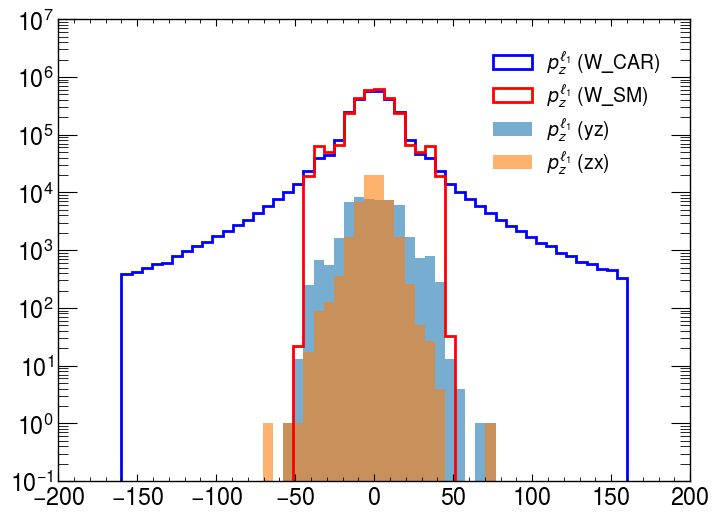

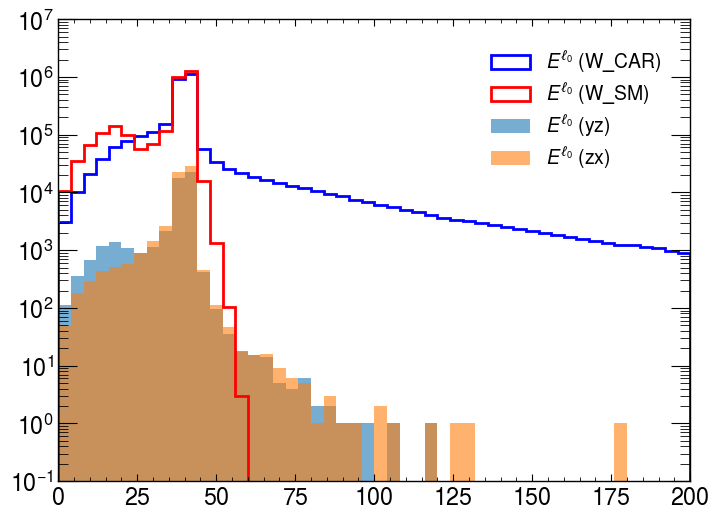

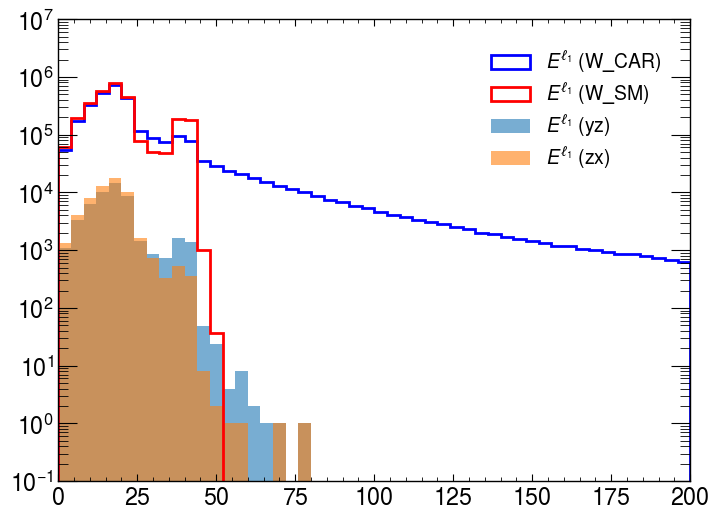

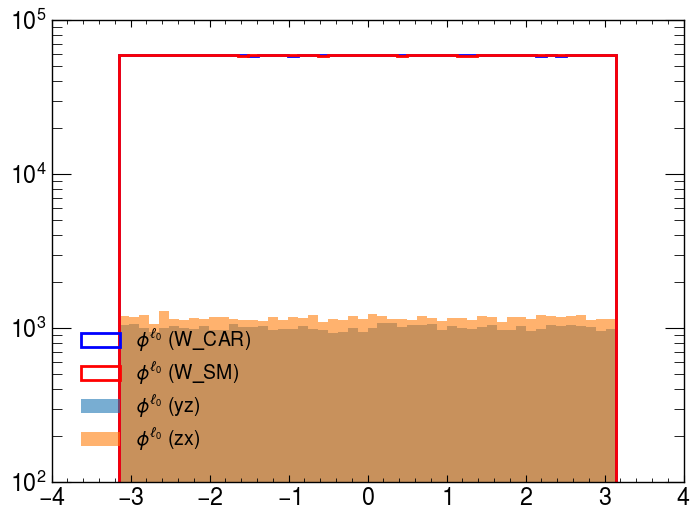

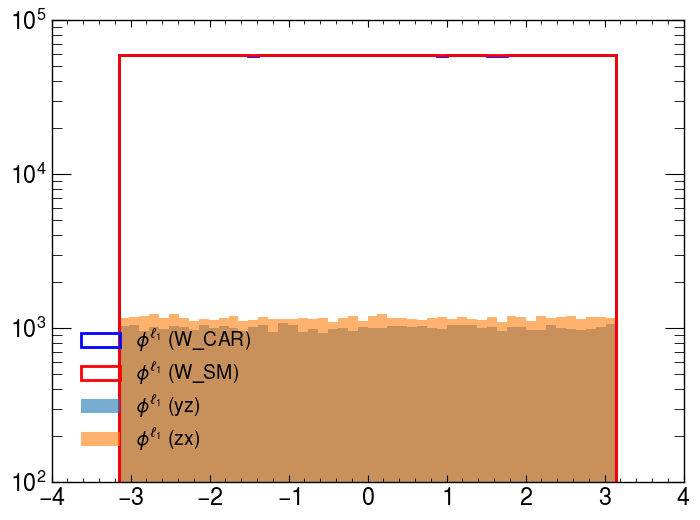

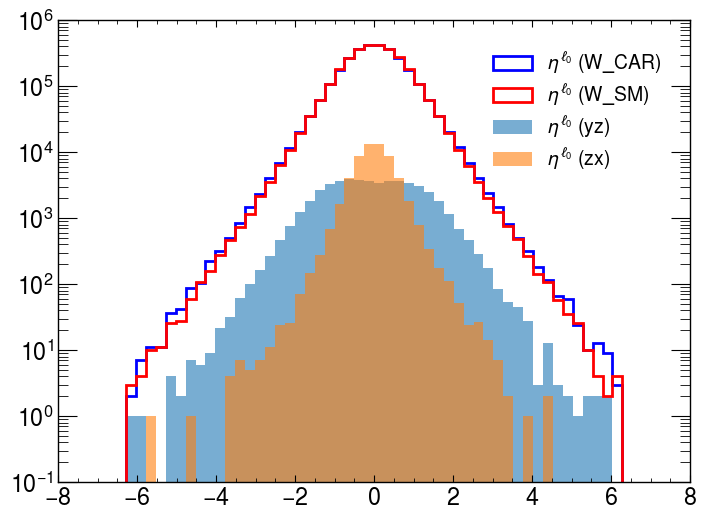

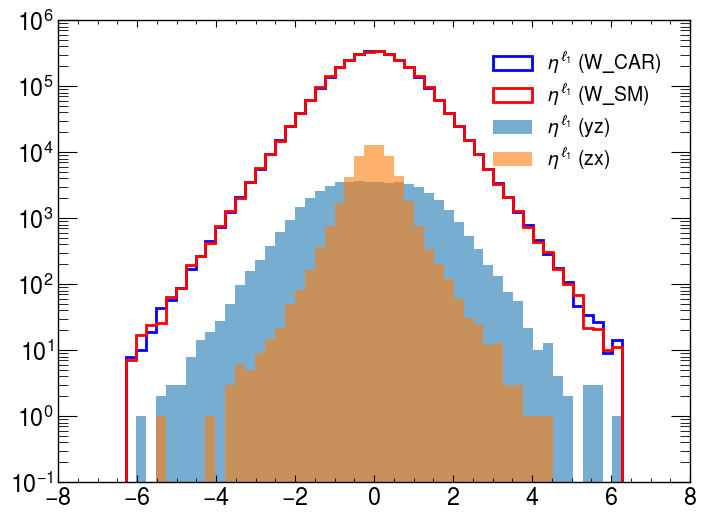

In [24]:
# lepton kinametics in the W(*) rest frame

bins_edges = np.linspace(-160, 160, 51)
plt.hist(truth_w_rest_lp_car[:,0], bins=bins_edges, label=r"$p_x^{\ell_0}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_w_rest_lp[:,0], bins=bins_edges, label=r"$p_x^{\ell_0}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_w_rest_lp_car[:,0][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_x^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_w_rest_lp_car[:,0][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_x^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_w_rest_ln_car[:,0], bins=bins_edges, label=r"$p_x^{\ell_1}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_w_rest_ln[:,0], bins=bins_edges, label=r"$p_x^{\ell_1}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_w_rest_ln_car[:,0][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_x^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_w_rest_ln_car[:,0][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_x^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-160, 160, 51)
plt.hist(truth_w_rest_lp_car[:,2], bins=bins_edges, label=r"$p_z^{\ell_0}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_w_rest_lp[:,2], bins=bins_edges, label=r"$p_z^{\ell_0}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_w_rest_lp_car[:,2][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_z^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_w_rest_lp_car[:,2][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_z^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_w_rest_ln_car[:,2], bins=bins_edges, label=r"$p_z^{\ell_1}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_w_rest_ln[:,2], bins=bins_edges, label=r"$p_z^{\ell_1}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_w_rest_ln_car[:,2][truth_bij_car_yz_mask], bins=bins_edges, label=r"$p_z^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_w_rest_ln_car[:,2][truth_bij_car_zx_mask], bins=bins_edges, label=r"$p_z^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(0, 200, 51)
plt.hist(truth_w_rest_lp_car[:,3], bins=bins_edges, label=r"$E^{\ell_0}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_w_rest_lp[:,3], bins=bins_edges, label=r"$E^{\ell_0}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_w_rest_lp_car[:,3][truth_bij_car_yz_mask], bins=bins_edges, label=r"$E^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_w_rest_lp_car[:,3][truth_bij_car_zx_mask], bins=bins_edges, label=r"$E^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
plt.hist(truth_w_rest_ln_car[:,3], bins=bins_edges, label=r"$E^{\ell_1}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_w_rest_ln[:,3], bins=bins_edges, label=r"$E^{\ell_1}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(truth_w_rest_ln_car[:,3][truth_bij_car_yz_mask], bins=bins_edges, label=r"$E^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(truth_w_rest_ln_car[:,3][truth_bij_car_zx_mask], bins=bins_edges, label=r"$E^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-np.pi, np.pi, 51)
lp_phi_car = phi(truth_w_rest_lp_car[:,0], truth_w_rest_lp_car[:,1])
lp_phi = phi(truth_w_rest_lp[:,0], truth_w_rest_lp[:,1])
plt.hist(lp_phi_car, bins=bins_edges, label=r"$\phi^{\ell_0}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_phi, bins=bins_edges, label=r"$\phi^{\ell_0}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(lp_phi_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\phi^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(lp_phi_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\phi^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
ln_phi_car = phi(truth_w_rest_ln_car[:,0], truth_w_rest_ln_car[:,1])
ln_phi = phi(truth_w_rest_ln[:,0], truth_w_rest_ln[:,1])
plt.hist(ln_phi_car, bins=bins_edges, label=r"$\phi^{\ell_1}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_phi, bins=bins_edges, label=r"$\phi^{\ell_1}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(ln_phi_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\phi^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(ln_phi_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\phi^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(-2*np.pi, 2*np.pi, 51)
lp_eta_car = eta(truth_w_rest_lp_car[:,0], truth_w_rest_lp_car[:,1], truth_w_rest_lp_car[:,2])
lp_eta = eta(truth_w_rest_lp[:,0], truth_w_rest_lp[:,1], truth_w_rest_lp[:,2])
plt.hist(lp_eta_car, bins=bins_edges, label=r"$\eta^{\ell_0}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(lp_eta, bins=bins_edges, label=r"$\eta^{\ell_0}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(lp_eta_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\eta^{\ell_0}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(lp_eta_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\eta^{\ell_0}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()
ln_eta_car = eta(truth_w_rest_ln_car[:,0], truth_w_rest_ln_car[:,1], truth_w_rest_ln_car[:,2])
ln_eta = eta(truth_w_rest_ln[:,0], truth_w_rest_ln[:,1], truth_w_rest_ln[:,2])
plt.hist(ln_eta_car, bins=bins_edges, label=r"$\eta^{\ell_1}$ (W_CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(ln_eta, bins=bins_edges, label=r"$\eta^{\ell_1}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(ln_eta_car[truth_bij_car_yz_mask], bins=bins_edges, label=r"$\eta^{\ell_1}$ (yz)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.6)
plt.hist(ln_eta_car[truth_bij_car_zx_mask], bins=bins_edges, label=r"$\eta^{\ell_1}$ (zx)", histtype="bar", linewidth=2, color="tab:orange", alpha=0.6)
plt.semilogy()
plt.legend()
plt.show()

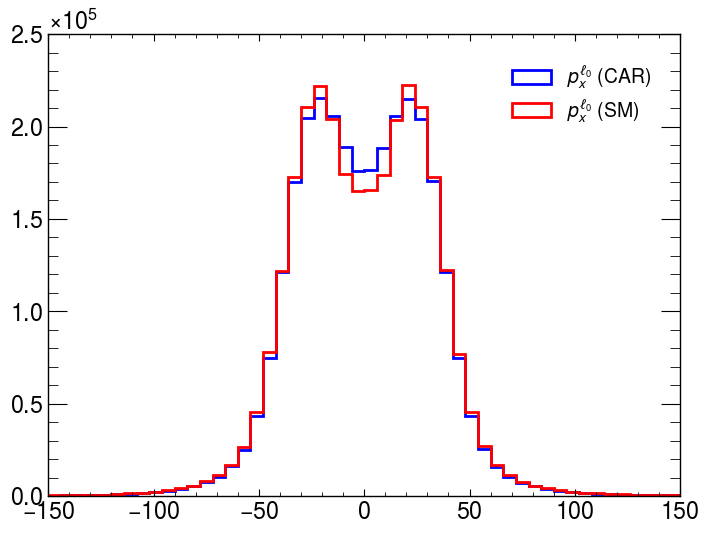

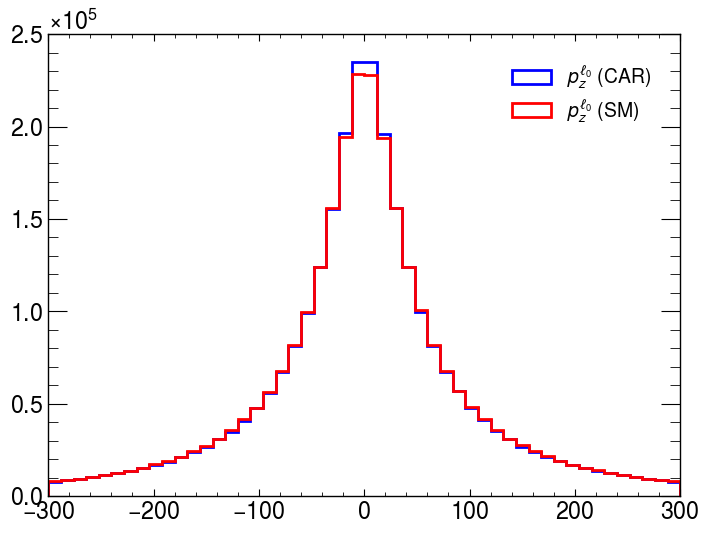

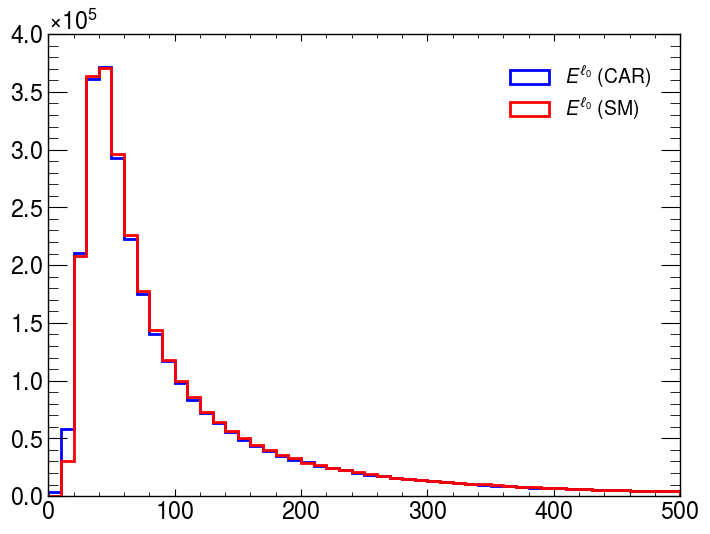

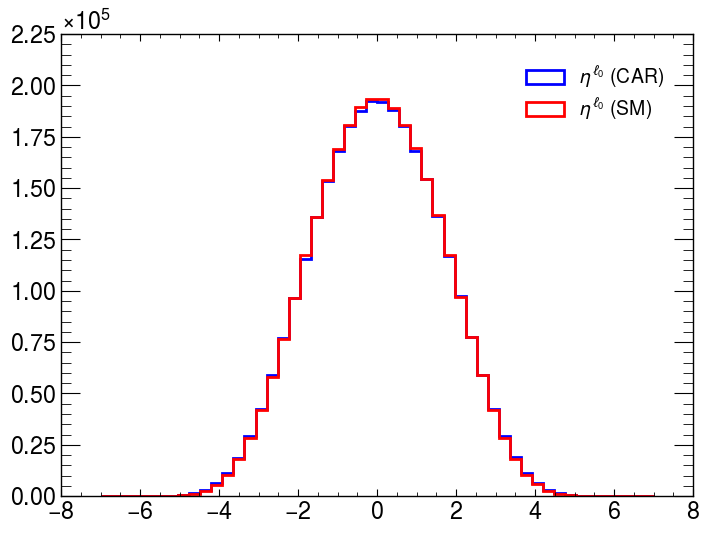

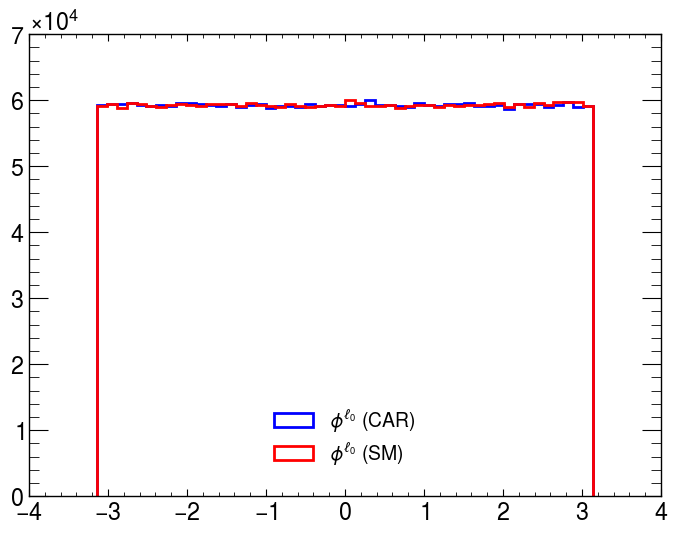

In [25]:
bins_edges = np.linspace(-150, 150, 51)
plt.hist(mc20_truth_lead_lep_car_p4[:,0], bins=bins_edges, label=r"$p_x^{\ell_0}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(mc20_truth_lead_lep_p4[:,0], bins=bins_edges, label=r"$p_x^{\ell_0}$ (SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
bins_edges = np.linspace(-300, 300, 51)
plt.hist(mc20_truth_lead_lep_car_p4[:,2], bins=bins_edges, label=r"$p_z^{\ell_0}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(mc20_truth_lead_lep_p4[:,2], bins=bins_edges, label=r"$p_z^{\ell_0}$ (SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
bins_edges = np.linspace(0, 500, 51)
plt.hist(mc20_truth_lead_lep_car_p4[:,3], bins=bins_edges, label=r"$E^{\ell_0}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(mc20_truth_lead_lep_p4[:,3], bins=bins_edges, label=r"$E^{\ell_0}$ (SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()

bins_edges = np.linspace(-7, 7, 51)
plt.hist(eta(mc20_truth_lead_lep_car_p4[:,0], mc20_truth_lead_lep_car_p4[:,1], mc20_truth_lead_lep_car_p4[:,2]), bins=bins_edges, label=r"$\eta^{\ell_0}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(eta(mc20_truth_lead_lep_p4[:,0], mc20_truth_lead_lep_p4[:,1], mc20_truth_lead_lep_p4[:,2]), bins=bins_edges, label=r"$\eta^{\ell_0}$ (SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()
bins_edges = np.linspace(-np.pi, np.pi, 51)
plt.hist(phi(mc20_truth_lead_lep_car_p4[:,0], mc20_truth_lead_lep_car_p4[:,1]), bins=bins_edges, label=r"$\phi^{\ell_0}$ (CAR)", histtype="step", linewidth=2, color="blue")
plt.hist(phi(mc20_truth_lead_lep_p4[:,0], mc20_truth_lead_lep_p4[:,1]), bins=bins_edges, label=r"$\phi^{\ell_0}$ (SM)", histtype="step", linewidth=2, color="red")
plt.legend()
plt.show()

In [26]:
# trim out nan values 

mask = ~truth_mask & ~truth_mask_car 

In [27]:
# variables for plotting

truth_bij = truth_bij[mask]
truth_bij_car = truth_bij_car[mask]
truth_xi_p = truth_xi_p[mask]
truth_xi_p_car = truth_xi_p_car[mask]
truth_xi_n = truth_xi_n[mask]
truth_xi_n_car = truth_xi_n_car[mask]

CAR (ground truth) vs SM (ground truth)


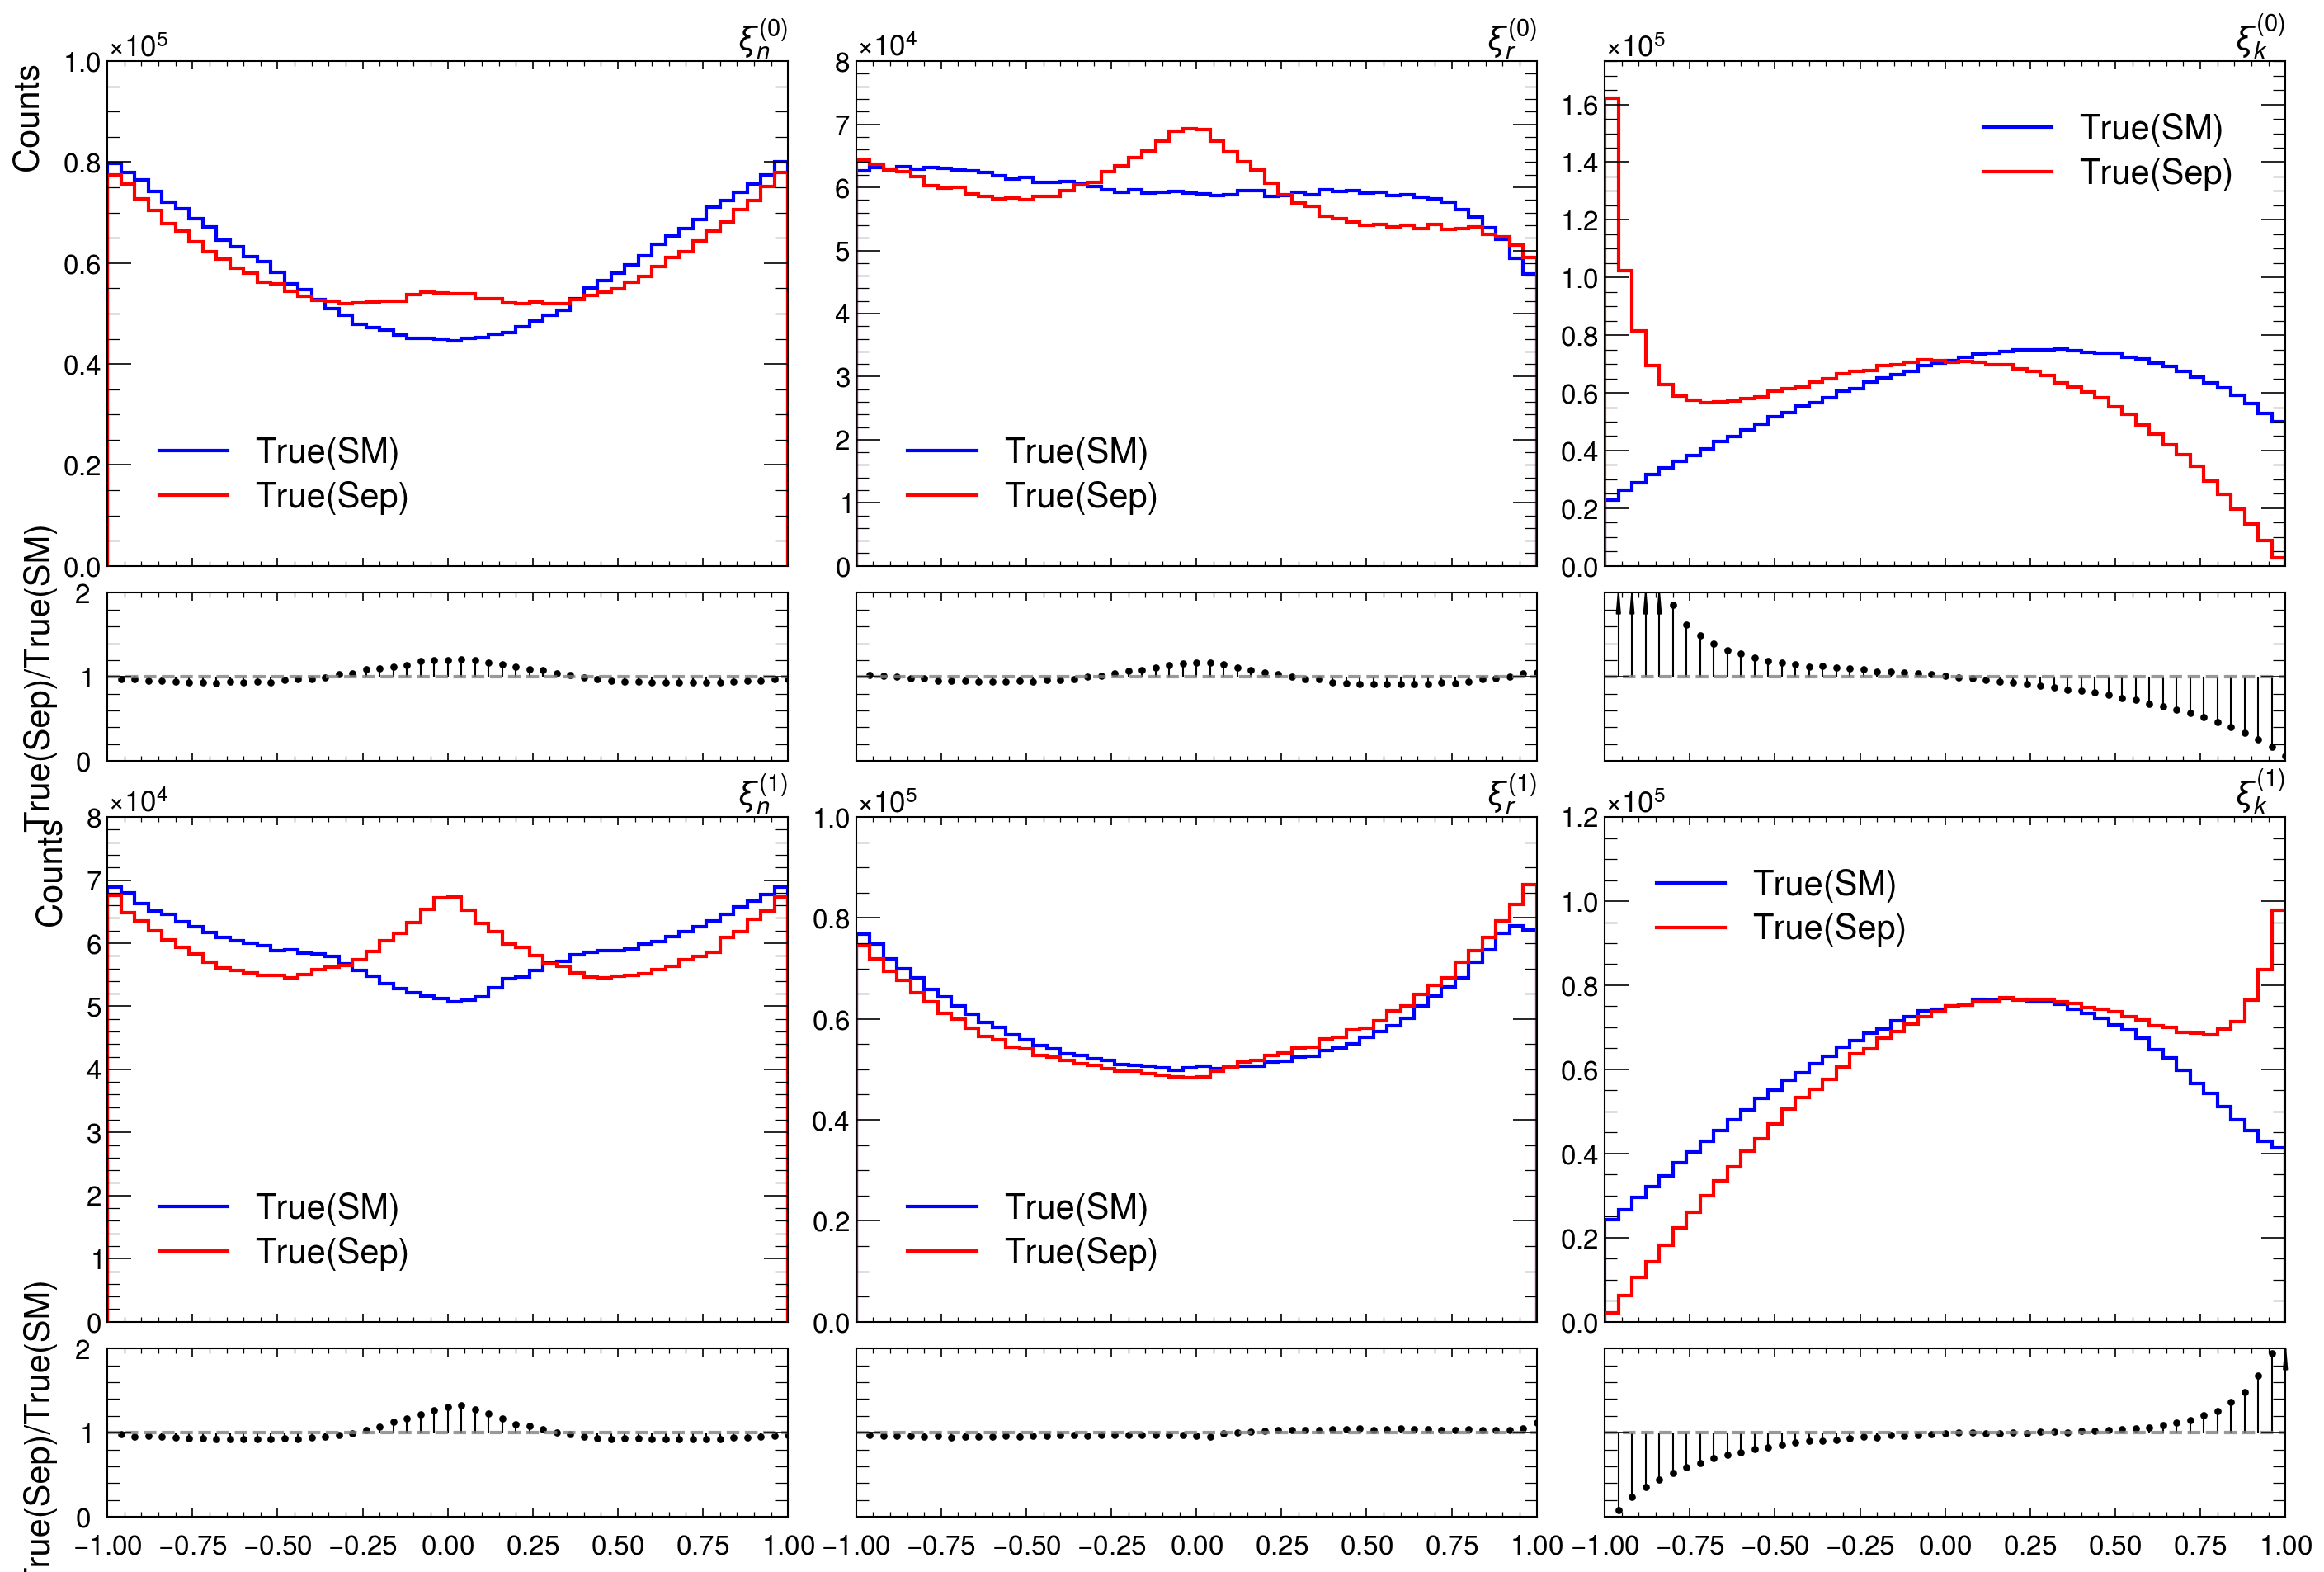

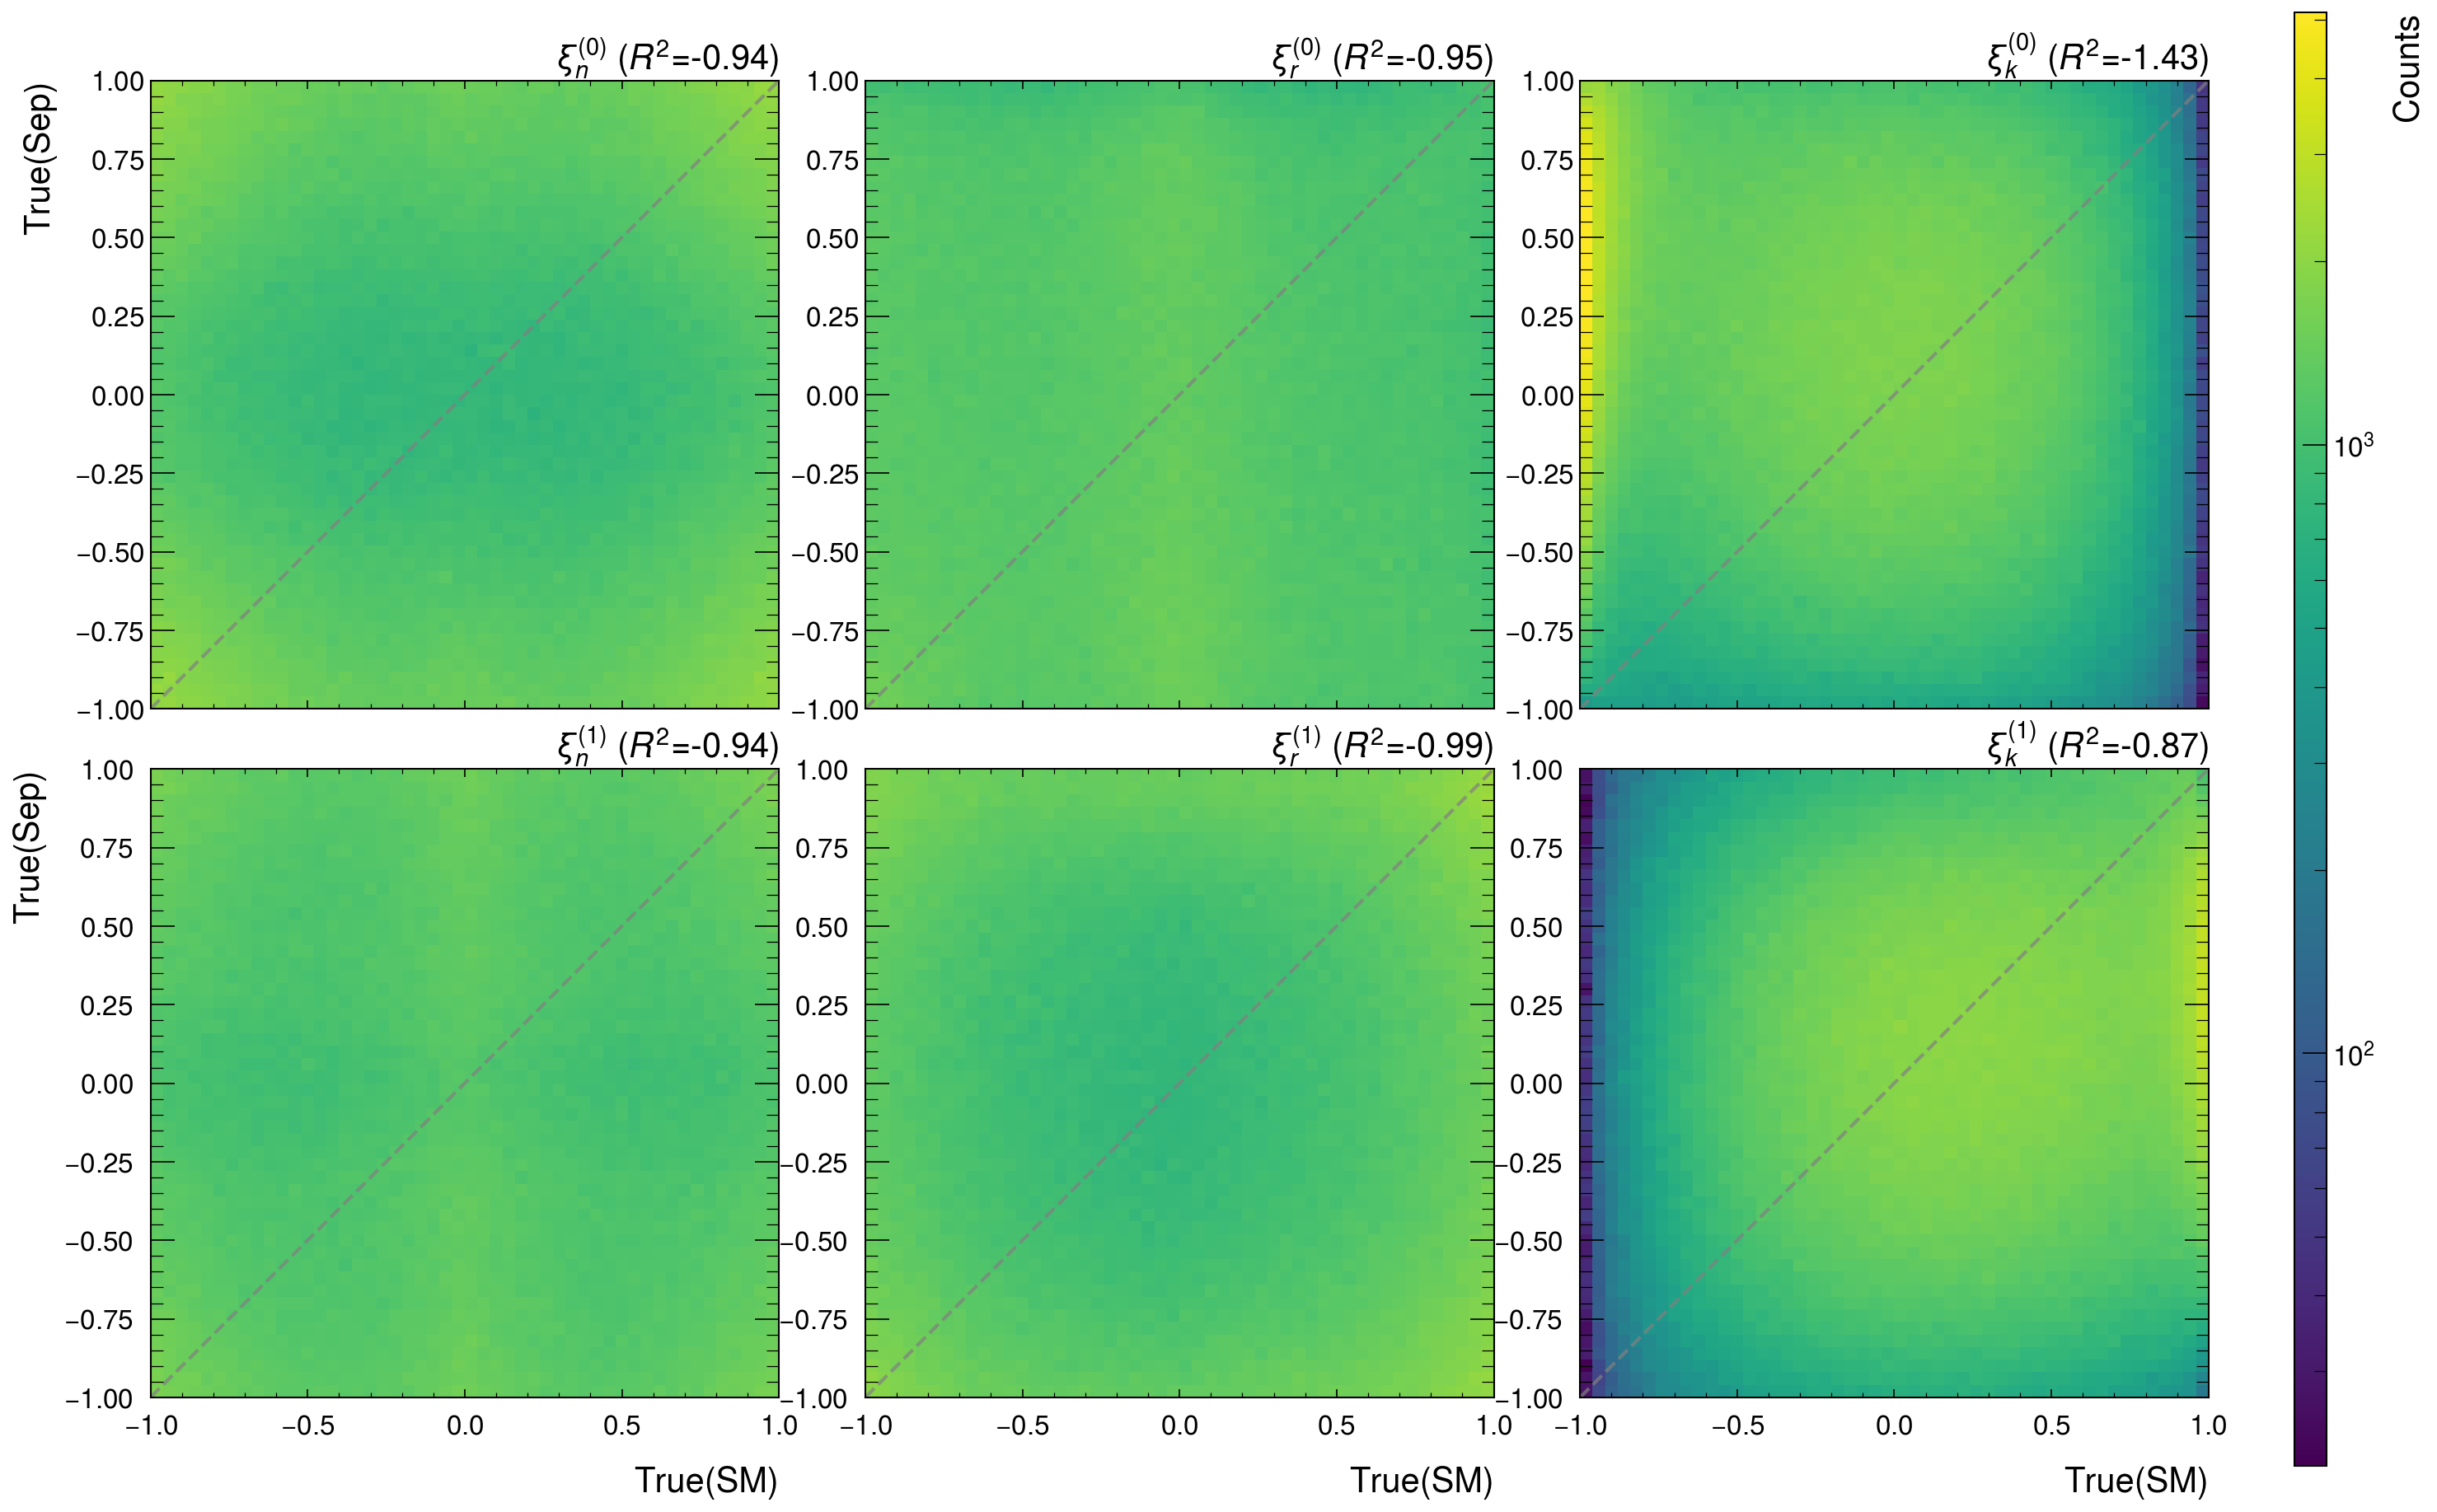

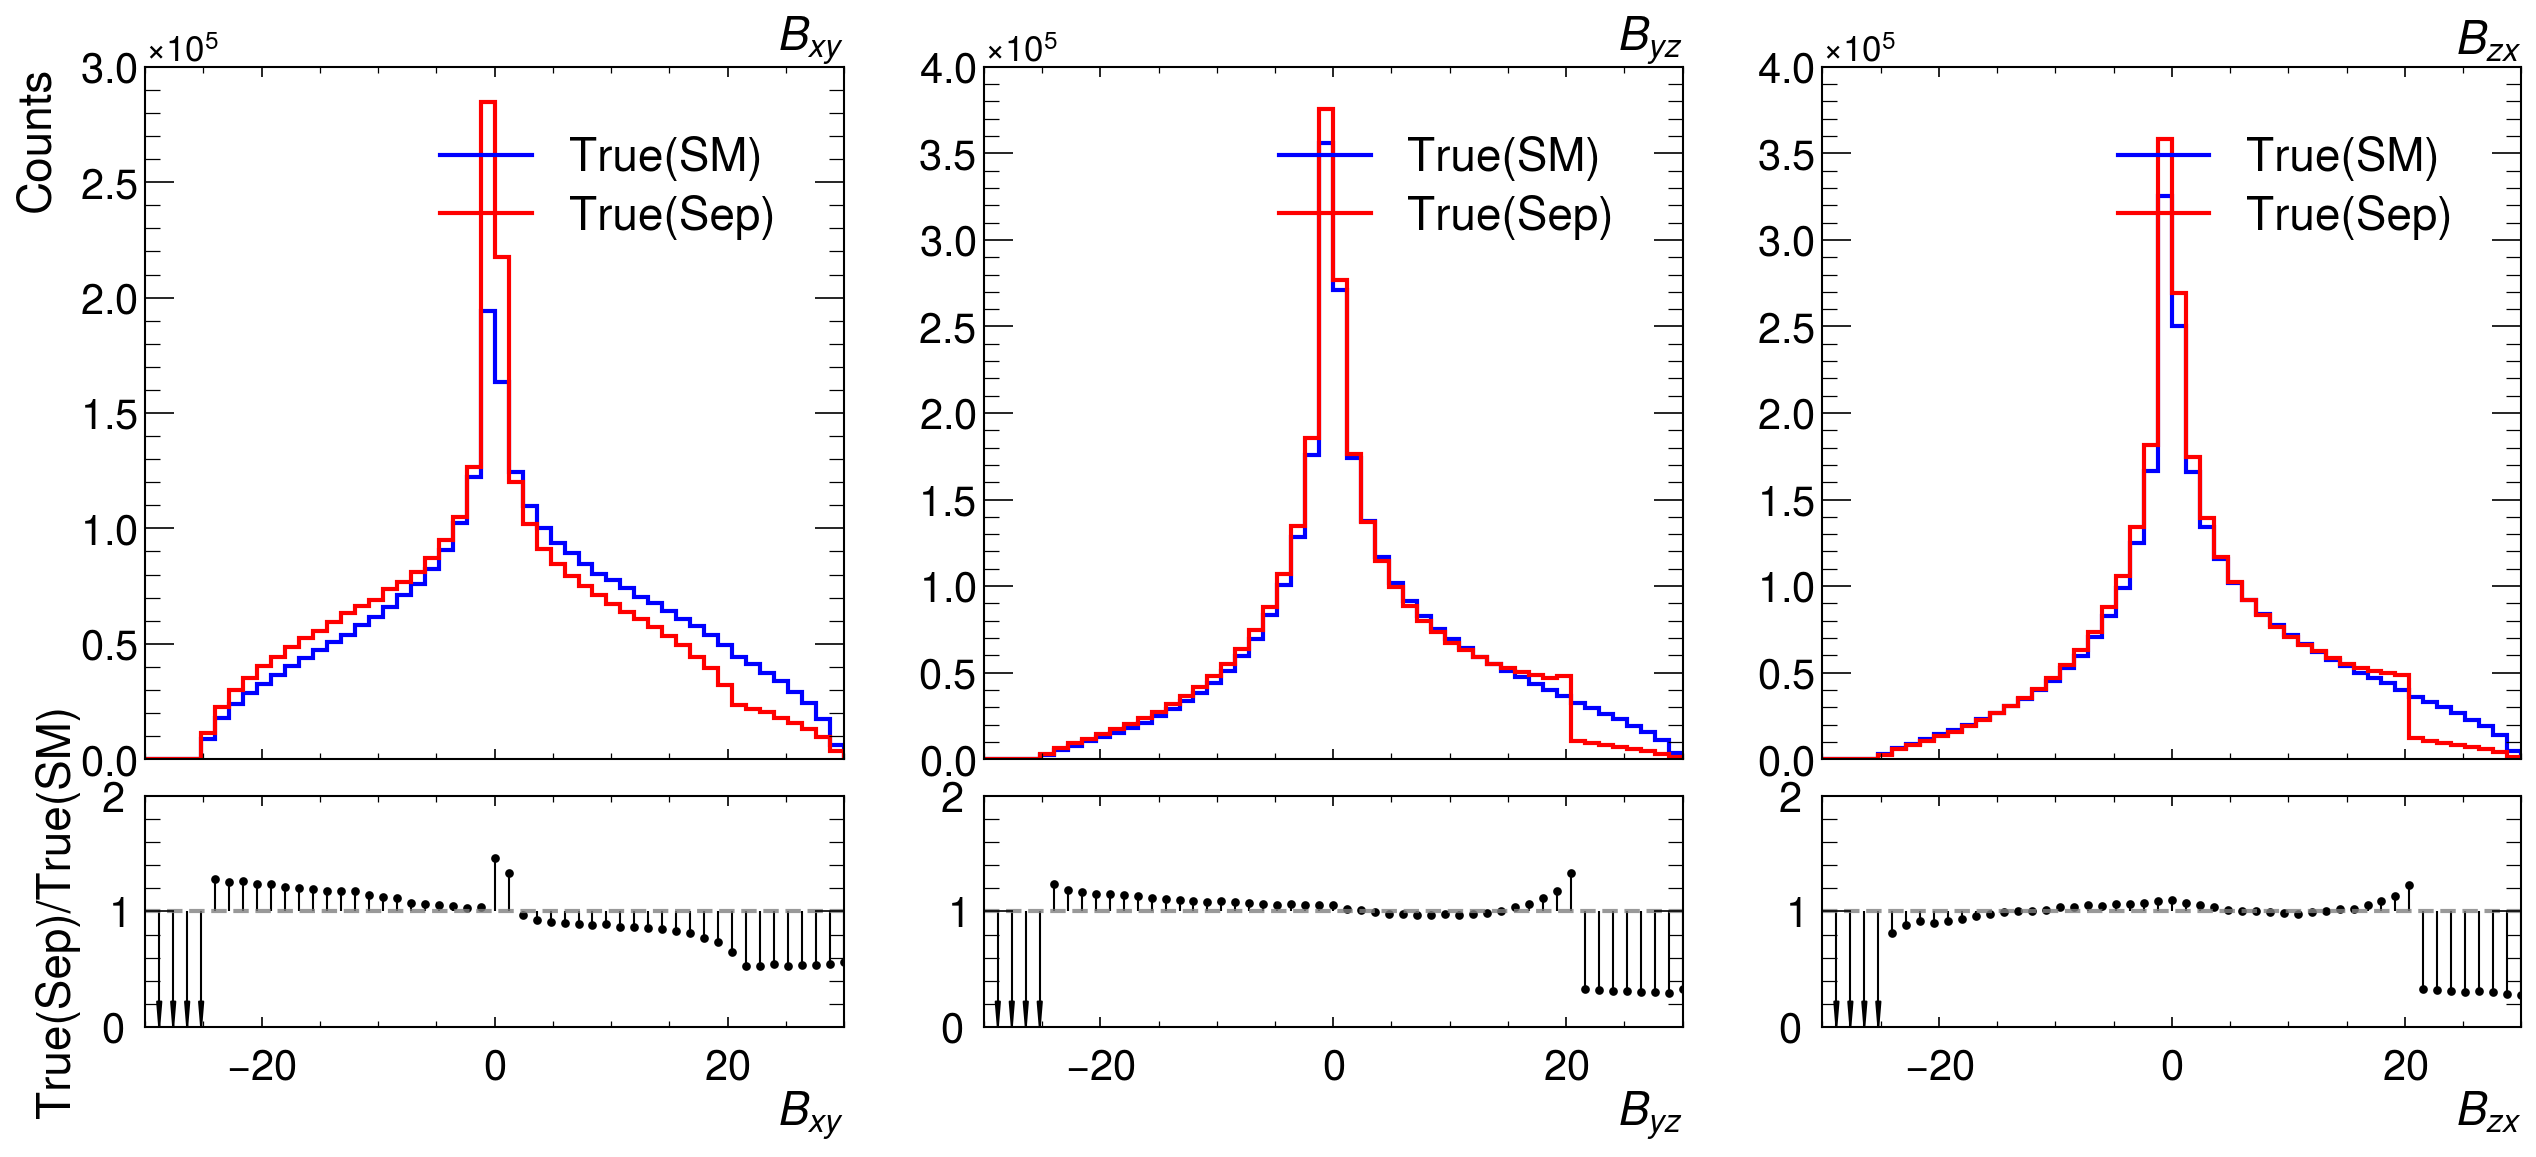


Bxy -> EMD:2.163, kl: 0.604 with SM mean:2.217, Sep mean 0.054
Byz -> EMD:0.971, kl: 0.515 with SM mean:2.499, Sep mean 1.528
Bzx -> EMD:0.968, kl: 0.595 with SM mean:2.748, Sep mean 1.833



In [28]:
# !
"""
Xi comparison:

CAR (ground truth) vs SM (ground truth)
"""

print("CAR (ground truth) vs SM (ground truth)")

# xi
xi_plot_true = [
    truth_xi_p[:, 0],
    truth_xi_p[:, 1],
    truth_xi_p[:, 2],
    truth_xi_n[:, 0],
    truth_xi_n[:, 1],
    truth_xi_n[:, 2],
]
xi_plot_pred = [
    truth_xi_p_car[:, 0],
    truth_xi_p_car[:, 1],
    truth_xi_p_car[:, 2],
    truth_xi_n_car[:, 0],
    truth_xi_n_car[:, 1],
    truth_xi_n_car[:, 2],
]
xi_plot_ranges = [[-1, 1]] * 6
xi_plot_labels = [
    r"$\xi^{(0)}_{n}$",
    r"$\xi^{(0)}_{r}$",
    r"$\xi^{(0)}_{k}$",
    r"$\xi^{(1)}_{n}$",
    r"$\xi^{(1)}_{r}$",
    r"$\xi^{(1)}_{k}$",
]
plot.hist_1d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    legend_lst=["True(Sep)", "True(SM)"],
    ranges=xi_plot_ranges,
    xlabel="",
)
plot.hist_2d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    ranges=xi_plot_ranges,
    xlabel="True(SM)",
    ylabel="True(Sep)",
)

# bij
bij_plot_true = [
    truth_bij[:, 0],
    truth_bij[:, 1],
    truth_bij[:, 2],
]
bij_plot_pred = [
    truth_bij_car[:, 0],
    truth_bij_car[:, 1],
    truth_bij_car[:, 2],
]
bij_plot_ranges = [[-30, 30]] * 3
bij_plot_labels = [
    r"$B_{xy}$",
    r"$B_{yz}$",
    r"$B_{zx}$",
]

plot.hist_1d3plot(
    bij_plot_true,
    bij_plot_pred,
    ranges=bij_plot_ranges,
    xlabel=bij_plot_labels,
    title=bij_plot_labels,
    row1_ylabel="Counts",
    row1_legend=["True(Sep)", "True(SM)"],
    xpad=1,
)

emd = [
    sp.stats.wasserstein_distance(truth_bij[:, i], truth_bij_car[:, i]) for i in range(3)
]

kl_lst = []
for i in range(3):
    # Create histograms
    p, bin_edges = np.histogram(truth_bij[..., i], bins=101, density=True)
    q, _ = np.histogram(truth_bij_car[..., i], bins=bin_edges, density=True)

    # Normalize histograms
    kl = np.sum(sp.special.kl_div(p, q+1e-10))
    kl_lst.append(kl)
    
mean_true = [np.mean(truth_bij[:, i]) for i in range(3)]
mean_car = [np.mean(truth_bij_car[:, i]) for i in range(3)]

print(
    rf"""
Bxy -> EMD:{emd[0]:.3f}, kl: {10*kl_lst[0]:.3f} with SM mean:{mean_true[0]:.3f}, Sep mean {mean_car[0]:.3f}
Byz -> EMD:{emd[1]:.3f}, kl: {10*kl_lst[1]:.3f} with SM mean:{mean_true[1]:.3f}, Sep mean {mean_car[1]:.3f}
Bzx -> EMD:{emd[2]:.3f}, kl: {10*kl_lst[2]:.3f} with SM mean:{mean_true[2]:.3f}, Sep mean {mean_car[2]:.3f}
"""
)

In [29]:
t_end = time.time()
print(f"Time elapsed: {t_end - t_start:.2f} s")
print("Done!")

Time elapsed: 135.65 s
Done!
